# BoG figures
4/29/24

the goal of this is to create a file that contains code to create all the figures and modify it if needed

## regression results

In [1]:
#now we should mask it and compare to see how it does
#can 
#first we will make the figure comparing the models
import torch
ctst_target_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_targets_reg.pt')
ctst_pred_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_predicts_class.pt')
ctst_pred_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_predicts_reg.pt')
ctst_target_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_targets_class.pt')

mult_target_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_targets_reg.pt')
mult_pred_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_predicts_reg.pt')
mult_target_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_targets_class.pt')
mult_pred_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_predicts_class.pt')

mult2_target_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_targets_reg.pt')
mult2_pred_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_predicts_reg.pt')
mult2_target_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_targets_class.pt')
mult2_pred_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_predicts_class.pt')

print(ctst_target_reg.shape, ctst_target_class.shape, ctst_pred_reg.shape, ctst_target_class.shape)
print(mult_target_reg.shape, mult_pred_reg.shape, mult_target_class.shape, mult_pred_class.shape) #all are identical as expected
#now make sure all the targets are identical for the reg and class
print(torch.all(ctst_target_reg == mult_target_reg))
print(torch.all(mult_target_reg == mult2_target_reg))
#perfect!
print(torch.all(ctst_target_class == mult_target_class))
print(torch.all(mult_target_class == mult2_target_class))
#now set a true targets since only need 1
t_class = ctst_target_class
t_reg = ctst_target_reg
t_reg

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])
torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])
tensor(True)
tensor(True)
tensor(True)
tensor(True)


tensor([[-10.0000,  -0.4581, -10.0000,  ..., -10.0000,  -1.7576, -10.0000],
        [-10.0000,  -1.1888, -10.0000,  ..., -10.0000,  -3.0268,  -2.2397],
        [  0.2071,   1.3613,  -2.4325,  ...,  -0.7399,   4.2481,  -0.7007],
        ...,
        [  0.9784,   0.6225,   0.2469,  ...,   0.3363,   0.6615,  -0.4536],
        [  1.4823,   1.6966,   0.2309,  ...,   0.2233,   0.8615,  -0.2049],
        [  0.8997,   0.8567,   0.4843,  ...,   0.1876,   0.8940,  -1.0668]])

In [2]:
#now we need to mask out the values
mask = t_reg != -10
mask

tensor([[False,  True, False,  ..., False,  True, False],
        [False,  True, False,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True]])

In [26]:
t_reg[0,mask[0,:]].shape #only 89! that's what we expect, now do this analysis and find correlations

torch.Size([72])

In [27]:
from scipy.stats import pearsonr
import numpy as np
from tqdm import tqdm
correlations_ctst = []
correlations_mult = []
correlations_mult2 = []
for i in tqdm(range(t_reg.shape[0])):
    # Apply the mask for the current row across all matrices
    current_mask = mask[i, :]
    t_reg_row = t_reg[i, current_mask]
    ctst_pred_reg_row = ctst_pred_reg[i, current_mask]
    mult_pred_reg_row = mult_pred_reg[i, current_mask]
    mult2_pred_reg_row = mult2_pred_reg[i, current_mask]
    corr, _ = pearsonr(t_reg_row, ctst_pred_reg_row)
    correlations_ctst.append(corr)

    corr, _ = pearsonr(t_reg_row, mult_pred_reg_row)
    correlations_mult.append(corr)

    corr, _ = pearsonr(t_reg_row, mult2_pred_reg_row)
    correlations_mult2.append(corr)

  0%|          | 0/105252 [00:00<?, ?it/s]

100%|██████████| 105252/105252 [05:02<00:00, 348.19it/s]


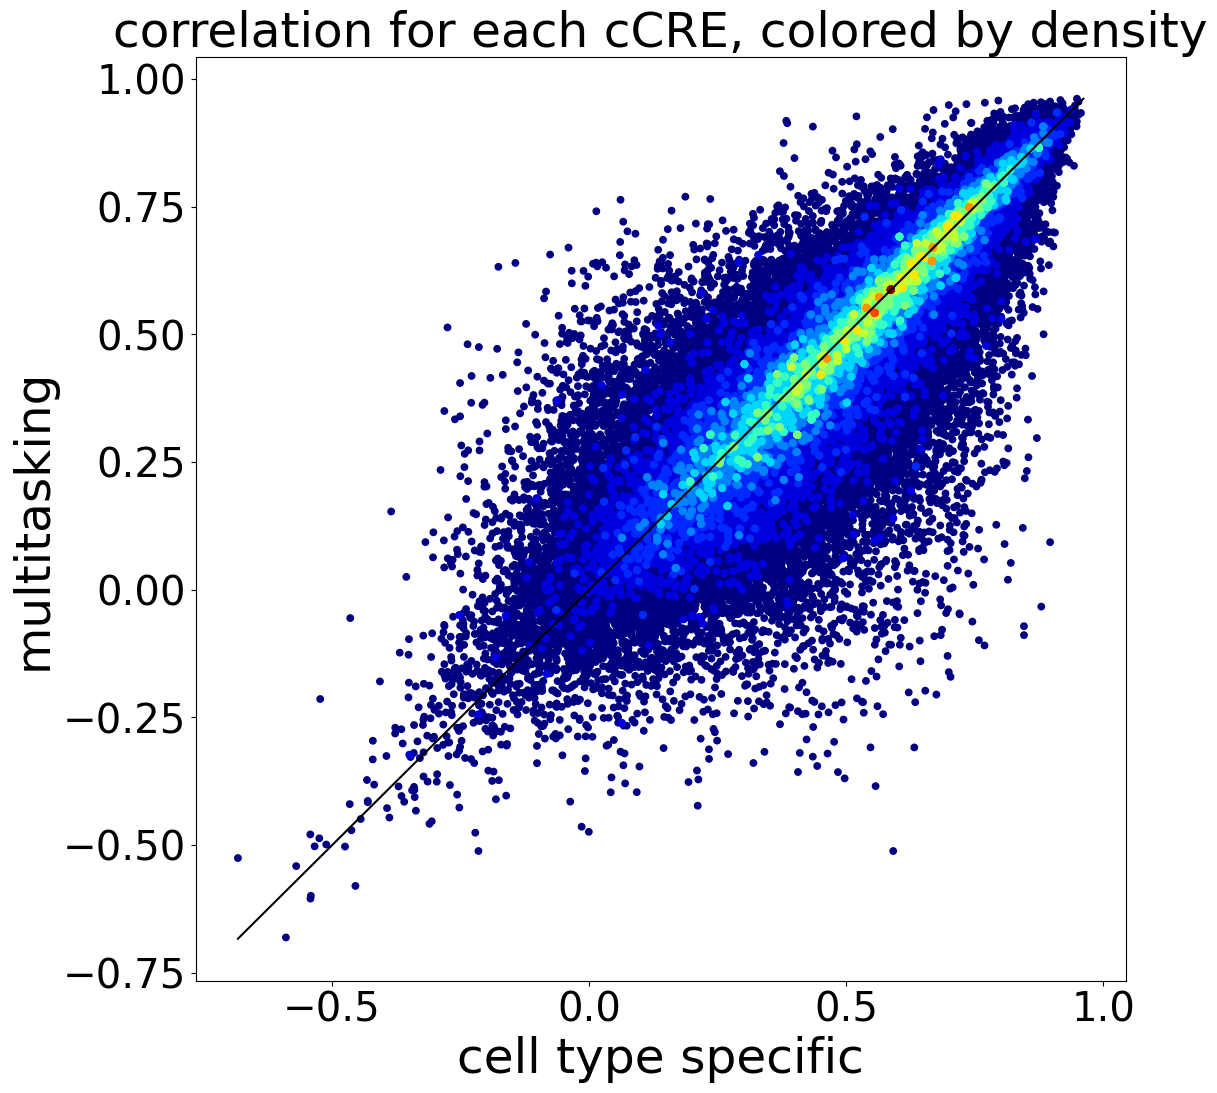

In [28]:
#this seems about right!
import matplotlib.pyplot as plt
x,y = np.array(correlations_ctst), np.array(correlations_mult2)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific', fontsize=35)
plt.ylabel('multitasking', fontsize=35)
plt.title('correlation for each cCRE, colored by density', fontsize=35)
plt.tick_params(labelsize=29)

In [29]:
#and find amount more
x,y = np.array(correlations_ctst), np.array(correlations_mult2)
z = x-y
print(np.sum(z>0), np.sum(z<0), np.sum(z==0))
print(np.sum(z>0)/(len(z))) #slightly more on ctst model

57579 47673 0
0.5470584881997492


In [3]:
#and let's do for the columns
from scipy.stats import pearsonr
import numpy as np
from tqdm import tqdm
correlations_col_ctst = []
correlations_col_mult = []
correlations_col_mult2 = []
for i in tqdm(range(t_reg.shape[1])):
    # Apply the mask for the current column across all matrices
    current_mask = mask[:, i]
    t_reg_col = t_reg[current_mask, i]
    ctst_pred_class_col = ctst_pred_class[current_mask, i]
    mult_pred_class_col = mult_pred_class[current_mask, i]
    mult2_pred_class_col = mult2_pred_class[current_mask, i]
    corr, _ = pearsonr(t_reg_col, ctst_pred_class_col)
    correlations_col_ctst.append(corr)

    corr, _ = pearsonr(t_reg_col, mult_pred_class_col)
    correlations_col_mult.append(corr)

    corr, _ = pearsonr(t_reg_col, mult2_pred_class_col)
    correlations_col_mult2.append(corr)

100%|██████████| 161/161 [00:03<00:00, 41.07it/s]


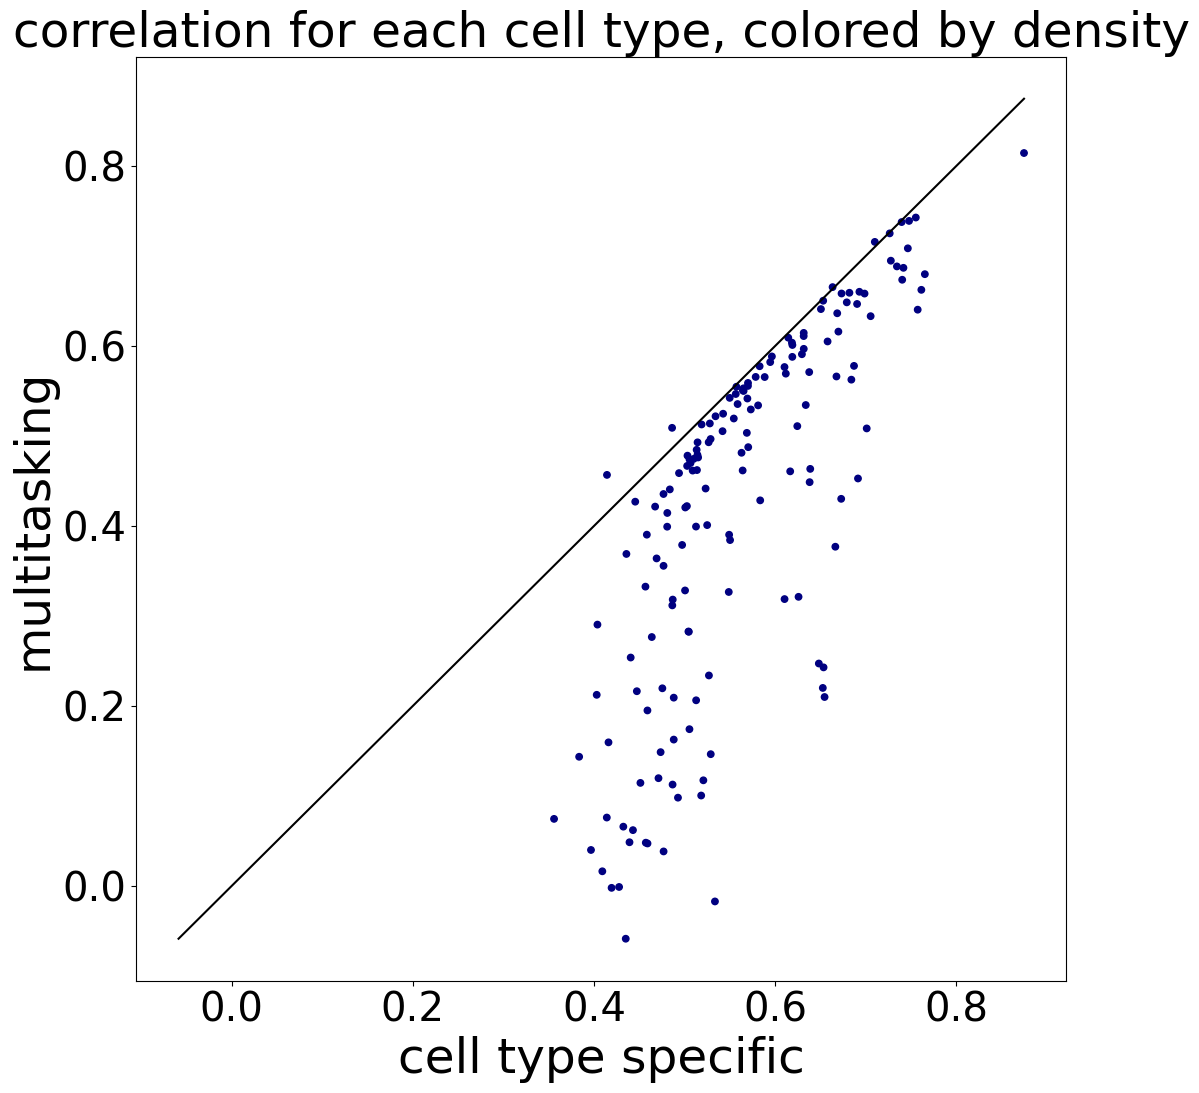

In [31]:
x,y = np.array(correlations_col_ctst), np.array(correlations_col_mult2)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(12,12)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.', s=85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific', fontsize=35)
plt.ylabel('multitasking', fontsize=35)
plt.title('correlation for each cell type, colored by density', fontsize=35)
plt.tick_params(labelsize=29)

In [5]:
x,y = np.array(correlations_col_ctst), np.array(correlations_col_mult2)
z = x-y
print(np.sum(z>0), np.sum(z<0), np.sum(z==0))
print(np.sum(z>0)/(len(z))) #slightly more on ctst model

157 4 0
0.9751552795031055


In [8]:
#print the median or mean of the groups
print(np.median(correlations_col_ctst), np.median(correlations_col_mult), np.median(correlations_col_mult2))
print(np.mean(correlations_col_ctst), np.mean(correlations_col_mult), np.mean(correlations_col_mult2))

0.54927557795727 0.5272553555775689 0.47001660755544106
0.5626009565228172 0.5059796474561644 0.42604746380090075


# checking celltype correlations

In [1]:
#the goal of this analysis is to see how correlated the outputs are
#now we should mask it and compare to see how it does
#can 
#first we will make the figure comparing the models
import torch
ctst_target_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_targets_reg.pt')
ctst_pred_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_predicts_class.pt')
ctst_pred_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_predicts_reg.pt')
ctst_target_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/ctst_bestepoch_targets_class.pt')

mult_target_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_targets_reg.pt')
mult_pred_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_predicts_reg.pt')
mult_target_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_targets_class.pt')
mult_pred_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_bestepoch_predicts_class.pt')

mult2_target_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_targets_reg.pt')
mult2_pred_reg = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_predicts_reg.pt')
mult2_target_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_targets_class.pt')
mult2_pred_class = torch.load('/data/leslie/sarthak/hyena/hyena-dna/evals/results/multitasking_25epoch_predicts_class.pt')

print(ctst_target_reg.shape, ctst_target_class.shape, ctst_pred_reg.shape, ctst_target_class.shape)
print(mult_target_reg.shape, mult_pred_reg.shape, mult_target_class.shape, mult_pred_class.shape) #all are identical as expected
#now make sure all the targets are identical for the reg and class
print(torch.all(ctst_target_reg == mult_target_reg))
print(torch.all(mult_target_reg == mult2_target_reg))
#perfect!
print(torch.all(ctst_target_class == mult_target_class))
print(torch.all(mult_target_class == mult2_target_class))
#now set a true targets since only need 1
t_class = ctst_target_class
t_reg = ctst_target_reg
# t_reg
#now we need to mask out the values
mask = t_reg != -10
# mask

torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])
torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161]) torch.Size([105252, 161])
tensor(True)
tensor(True)
tensor(True)
tensor(True)


In [3]:
#now we have to correlate every row of the matrix
import numpy as np
outputs_np = t_reg.numpy()

# Calculate the correlation matrix using NumPy
correlation_matrix = np.corrcoef(outputs_np, rowvar=False)

print(correlation_matrix.shape) #correlates every celltype with every other celltype!!

# If you need to adjust for multiple comparisons, consider using a threshold for significance
# Example: Filter correlations that are above a certain absolute value threshold
# threshold = 0.5
# significant_correlations = np.where(np.abs(correlation_matrix) > threshold)

# Print or process the significant correlations
# print("Significant correlations indices:", significant_correlations)
# print("Correlation values:", correlation_matrix[significant_correlations])

# Optional: Visualize the correlation matrix using matplotlib


(161, 161)


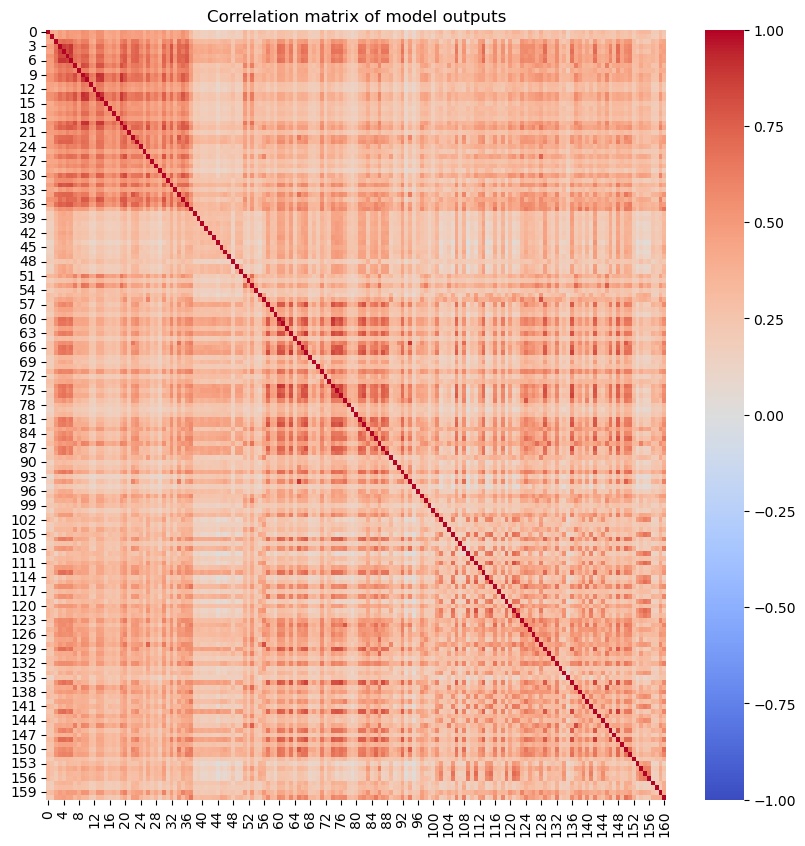

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation matrix of model outputs')
plt.show()

Text(0.5, 1.0, 'multitasking model 2')

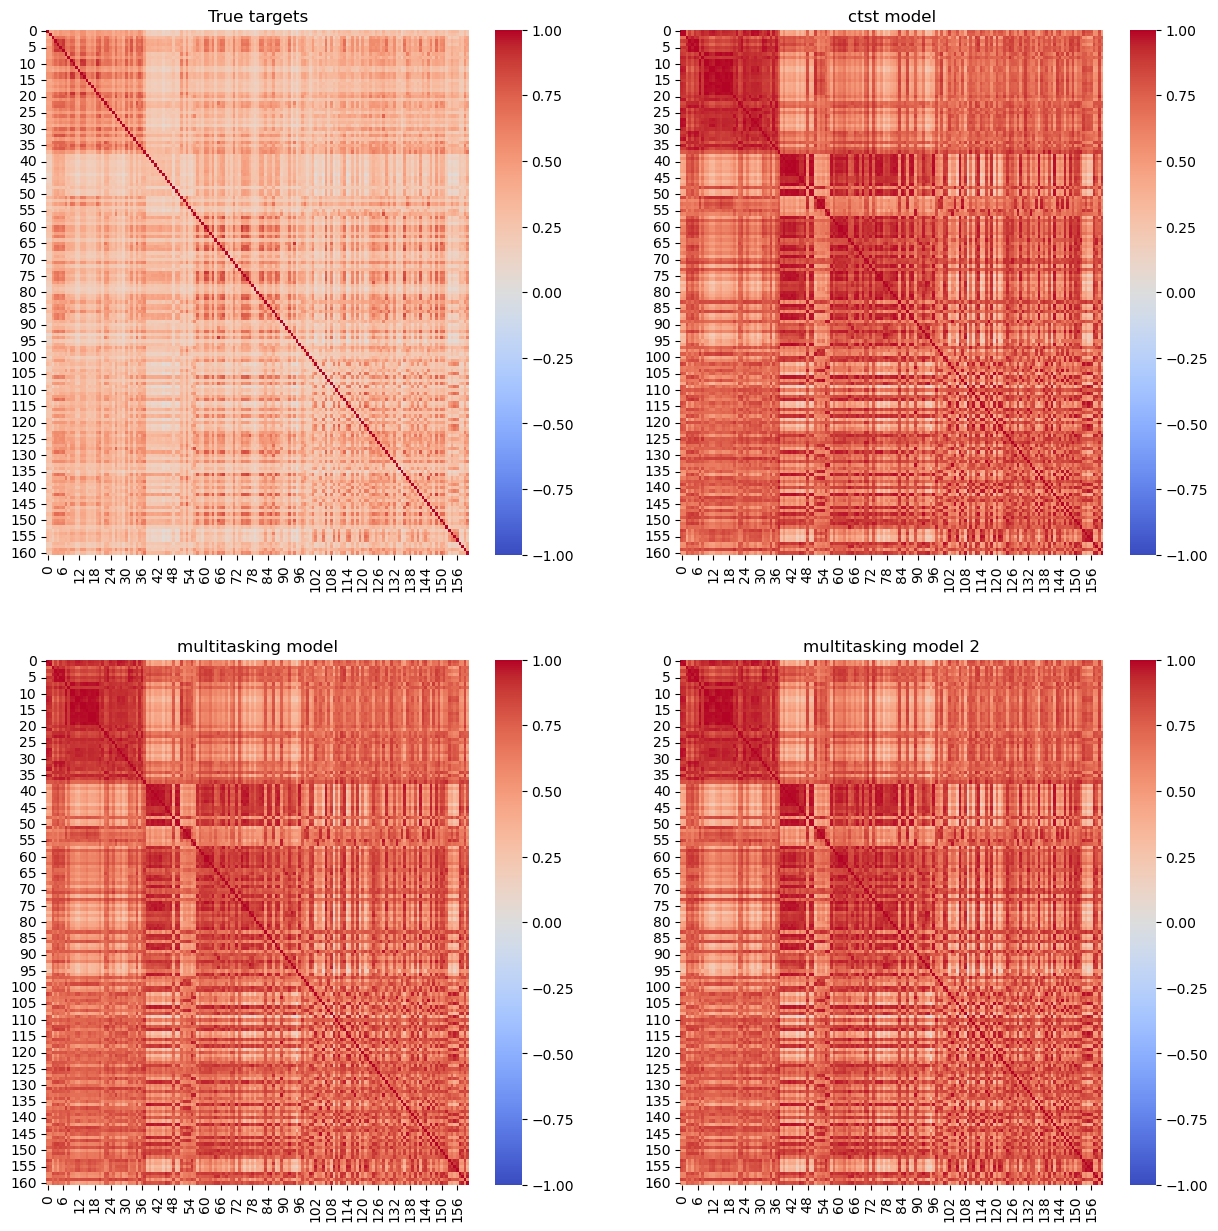

In [6]:
correlation_matrix_true = np.corrcoef(t_reg.numpy(), rowvar=False)
correlation_matrix_ctst = np.corrcoef(ctst_pred_reg.numpy(), rowvar=False)
correlation_matrix_mult = np.corrcoef(mult_pred_reg.numpy(), rowvar=False)
correlation_matrix_mult2 = np.corrcoef(mult2_pred_reg.numpy(), rowvar=False)

#now plot all 4 in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')

In [7]:
print(np.mean(correlation_matrix_true), np.mean(correlation_matrix_ctst), np.mean(correlation_matrix_mult), np.mean(correlation_matrix_mult2))

0.3517594643475041 0.7099330960113763 0.698108370149721 0.7118649473198685


In [8]:
#now we need to mask out the values, this is likely the true culprit
#we will just do a for loop and calculate it this way
correlation_matrix_true = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_ctst = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_mult = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_mult2 = np.zeros((t_reg.shape[1], t_reg.shape[1]))
for i in range(t_reg.shape[1]):
    for j in range(i, t_reg.shape[1]):
        # Apply the mask for the current row across all matrices
        # now we mask out the vectors
        correlation_matrix_true[i, j] = np.corrcoef(t_reg[:, i][mask[:, i]], t_reg[:, j][mask[:, j]])[0, 1]
        correlation_matrix_ctst[i, j] = np.corrcoef(ctst_pred_reg[:, i][mask[:, i]], ctst_pred_reg[:, j][mask[:, j]])[0, 1]
        correlation_matrix_mult[i, j] = np.corrcoef(mult_pred_reg[:, i][mask[:, i]], mult_pred_reg[:, j][mask[:, j]])[0, 1]
        correlation_matrix_mult2[i, j] = np.corrcoef(mult2_pred_reg[:, i][mask[:, i]], mult2_pred_reg[:, j][mask[:, j]])[0, 1]

#now plot all 4 in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 98778 and the array at index 1 has size 100127

In [10]:
print(t_reg[:, i][mask[:, i]].shape, t_reg[:, j][mask[:, j]].shape)

torch.Size([98778]) torch.Size([100127])


In [11]:
#let's do it with pearsonr instead
from scipy.stats import pearsonr
correlation_matrix_true = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_ctst = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_mult = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_mult2 = np.zeros((t_reg.shape[1], t_reg.shape[1]))
for i in range(t_reg.shape[1]):
    for j in range(i, t_reg.shape[1]):
        # Apply the mask for the current row across all matrices
        # now we mask out the vectors
        correlation_matrix_true[i, j], _ = pearsonr(t_reg[:, i][mask[:, i]], t_reg[:, j][mask[:, j]])
        correlation_matrix_ctst[i, j], _ = pearsonr(ctst_pred_reg[:, i][mask[:, i]], ctst_pred_reg[:, j][mask[:, j]])
        correlation_matrix_mult[i, j], _ = pearsonr(mult_pred_reg[:, i][mask[:, i]], mult_pred_reg[:, j][mask[:, j]])
        correlation_matrix_mult2[i, j], _ = pearsonr(mult2_pred_reg[:, i][mask[:, i]], mult2_pred_reg[:, j][mask[:, j]])

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')

ValueError: x and y must have the same length.

In [12]:
#finally we do the same approach as above, but we use this combined mask which combines both masks
correlation_matrix_true = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_ctst = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_mult = np.zeros((t_reg.shape[1], t_reg.shape[1]))
correlation_matrix_mult2 = np.zeros((t_reg.shape[1], t_reg.shape[1]))
for i in range(t_reg.shape[1]):
    for j in range(i, t_reg.shape[1]):
        # Apply the mask for the current row across all matrices
        # now we mask out the vectors
        current_mask = mask[:, i] & mask[:, j]
        correlation_matrix_true[i, j], _ = pearsonr(t_reg[:, i][current_mask], t_reg[:, j][current_mask])
        correlation_matrix_ctst[i, j], _ = pearsonr(ctst_pred_reg[:, i][current_mask], ctst_pred_reg[:, j][current_mask])
        correlation_matrix_mult[i, j], _ = pearsonr(mult_pred_reg[:, i][current_mask], mult_pred_reg[:, j][current_mask])
        correlation_matrix_mult2[i, j], _ = pearsonr(mult2_pred_reg[:, i][current_mask], mult2_pred_reg[:, j][current_mask])

0.2425871988215912 0.357904243298567 0.35225275951171064 0.35974741117805614


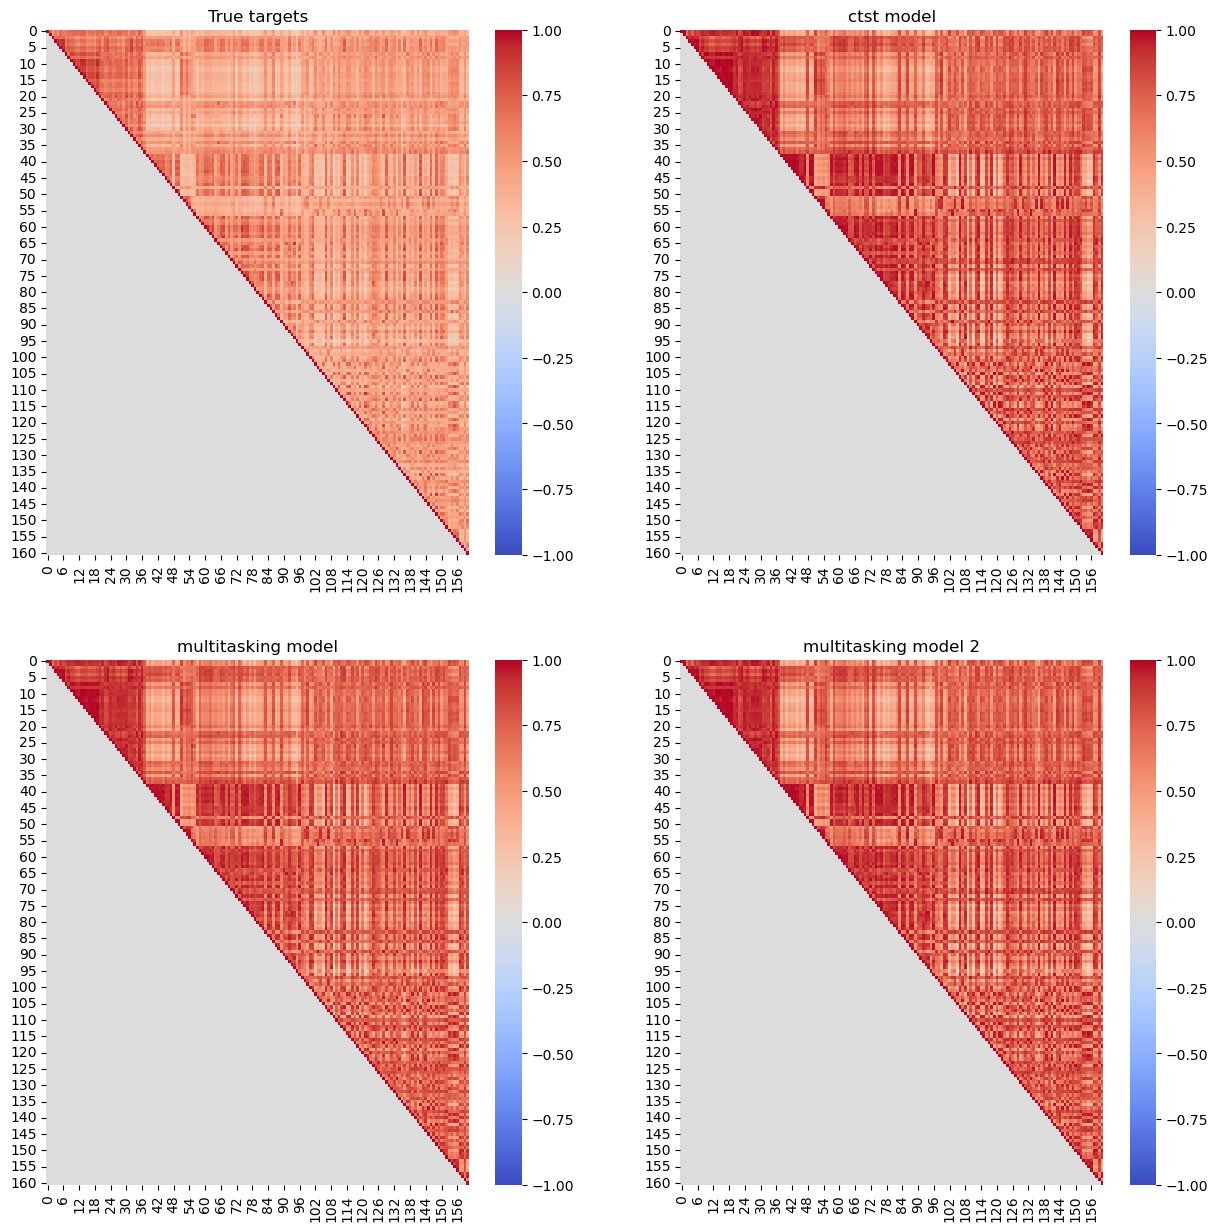

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')
print(np.mean(correlation_matrix_true), np.mean(correlation_matrix_ctst), np.mean(correlation_matrix_mult), np.mean(correlation_matrix_mult2))

In [15]:
#ahh no that's wrong, actually want to correlate across the individual samples, shows how correlated the outputs are
correlation_matrix_true = np.corrcoef(t_reg.numpy(), rowvar=True)
correlation_matrix_ctst = np.corrcoef(ctst_pred_reg.numpy(), rowvar=True)
correlation_matrix_mult = np.corrcoef(mult_pred_reg.numpy(), rowvar=True)
correlation_matrix_mult2 = np.corrcoef(mult2_pred_reg.numpy(), rowvar=True)

#now plot all 4 in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')

#issue with the size, can't do this, it's way way too large

: 

In [ ]:
#final thing we want to do is let's correlate the open regions in each cell type with the closed ones in the others
#what this means is that we see how different it is between open and closed value predictions?
#not ideal since again for closed ones we just ignore it...

#no, let's instead impute the closed values, and then correlate them. We can just impute the true -10 values for the closed regions!
#let's try imputing -10, and then try imputing 0, and then try imputing the mean!

#let's try imputing the mean instead, the -10 might skew the results a lot
# t_reg_imputed[t_reg_imputed == -10] = 
#now the question is do we average across the CRE, the cell type or all?
#definitely the CRE
ctst_pred_reg_imputed = ctst_pred_reg.clone()
ctst_pred_reg_imputed[t_reg == -10] = ctst_pred_reg_imputed[ctst_pred_reg_imputed != -10].mean()
#but this is for it imputing the mean of the full matrix, should do it across each row separately

Text(0.5, 1.0, 'multitasking model 2')

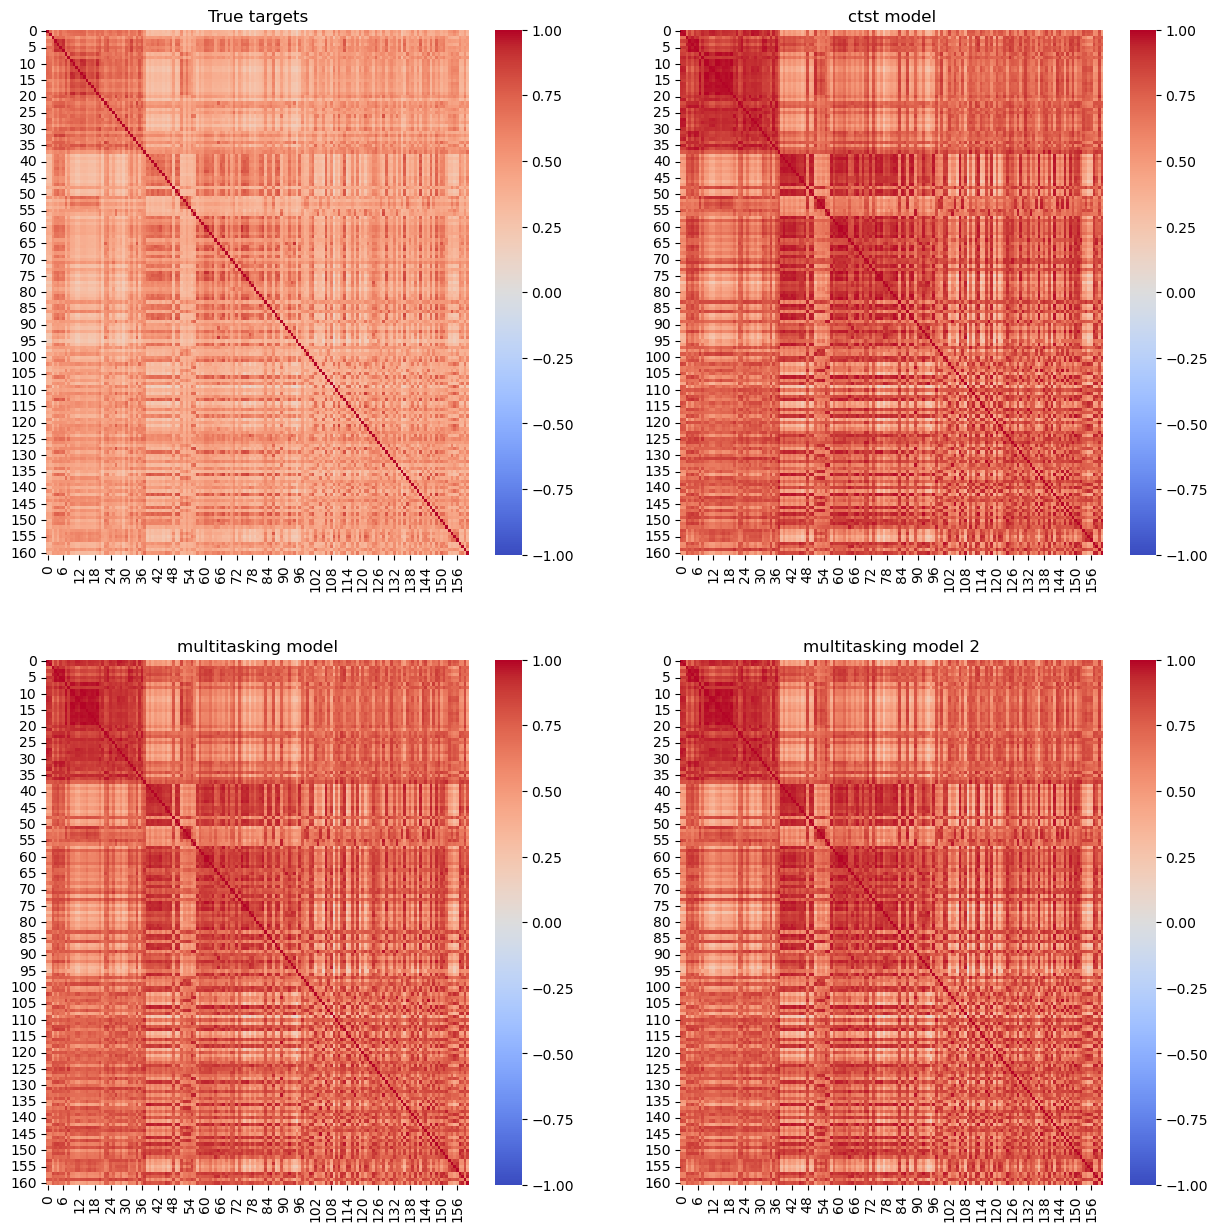

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
ctst_pred_reg_imputed = ctst_pred_reg.clone()
mult_pred_reg_imputed = mult_pred_reg.clone()
mult2_pred_reg_imputed = mult2_pred_reg.clone()
t_reg_imputed = t_reg.clone()
for i in range(t_reg.shape[0]):
    tempmask = t_reg[i, :] != -10
    ctst_pred_reg_imputed[i, ~tempmask] = ctst_pred_reg_imputed[i, tempmask].mean() #impute the mean of the rest in that row
    mult_pred_reg_imputed[i, ~tempmask] = mult_pred_reg_imputed[i, tempmask].mean() #impute the mean of the rest in that row
    mult2_pred_reg_imputed[i, ~tempmask] = mult2_pred_reg_imputed[i, tempmask].mean() #impute the mean of the rest in that row
    t_reg_imputed[i, ~tempmask] = t_reg_imputed[i, tempmask].mean() #impute the mean of the rest in that row

#now that it's imputed we don't mask just do the corrcoef
correlation_matrix_true = np.corrcoef(t_reg_imputed.numpy(), rowvar=False)
correlation_matrix_ctst = np.corrcoef(ctst_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult = np.corrcoef(mult_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult2 = np.corrcoef(mult2_pred_reg_imputed.numpy(), rowvar=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')


In [24]:
t_reg

tensor([[-10.0000,  -0.4581, -10.0000,  ..., -10.0000,  -1.7576, -10.0000],
        [-10.0000,  -1.1888, -10.0000,  ..., -10.0000,  -3.0268,  -2.2397],
        [  0.2071,   1.3613,  -2.4325,  ...,  -0.7399,   4.2481,  -0.7007],
        ...,
        [  0.9784,   0.6225,   0.2469,  ...,   0.3363,   0.6615,  -0.4536],
        [  1.4823,   1.6966,   0.2309,  ...,   0.2233,   0.8615,  -0.2049],
        [  0.8997,   0.8567,   0.4843,  ...,   0.1876,   0.8940,  -1.0668]])

Text(0.5, 1.0, 'Violin Plot of Upper Triangle Correlation Values')

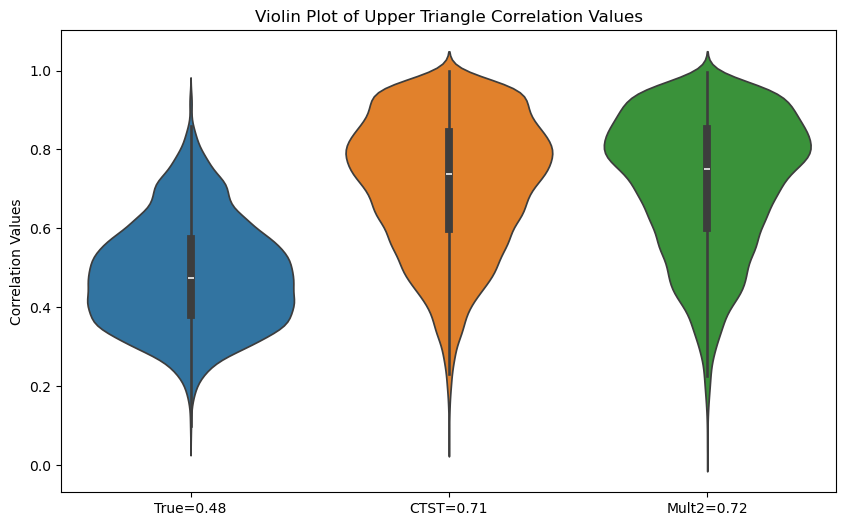

In [19]:
#let's do violinplot of the upper triangle values
def upper_triangle_values(correlation_matrix):
    upper_tri_indices = np.triu_indices_from(correlation_matrix, k=1)
    return correlation_matrix[upper_tri_indices]

# Extracting upper triangle values for each correlation matrix
values_true = upper_triangle_values(correlation_matrix_true)
values_ctst = upper_triangle_values(correlation_matrix_ctst)
values_mult = upper_triangle_values(correlation_matrix_mult)
values_mult2 = upper_triangle_values(correlation_matrix_mult2)

# Prepare data for violin plot
data = [
    values_true,
    values_ctst,
    # values_mult,
    values_mult2
]

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
# names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult={np.mean(values_mult):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
plt.xticks([0, 1, 2], names)
plt.ylabel('Correlation Values')
plt.title('Violin Plot of Upper Triangle Correlation Values')

(array([2.26000e+02, 1.45000e+03, 5.73300e+03, 1.68990e+04, 9.07480e+04,
        2.88508e+05, 2.23526e+05, 1.12102e+05, 5.44570e+04, 2.72500e+04,
        1.35980e+04, 6.65900e+03, 3.23500e+03, 1.70100e+03, 7.32000e+02,
        3.28000e+02, 9.80000e+01, 2.30000e+01, 5.00000e+00, 1.00000e+00]),
 array([-2.85738611, -2.35215807, -1.84692991, -1.34170175, -0.83647364,
        -0.33124554,  0.17398258,  0.67921066,  1.18443882,  1.68966687,
         2.19489503,  2.70012307,  3.20535135,  3.7105794 ,  4.21580744,
         4.72103548,  5.22626352,  5.73149204,  6.23672009,  6.74194813,
         7.24717617]),
 <BarContainer object of 20 artists>)

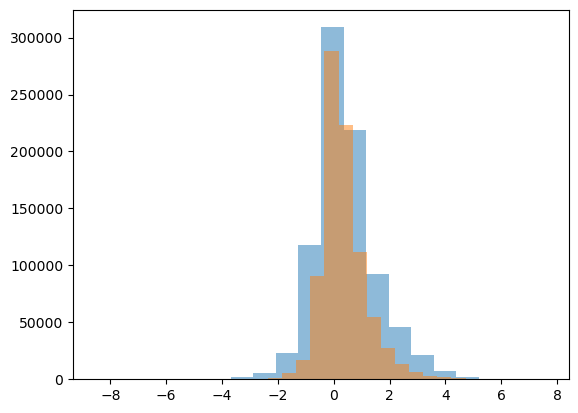

In [11]:
plt.hist(t_reg_imputed.flatten()[::20], bins=20, alpha=0.5) #just making sure there are no -10 values...
plt.hist(ctst_pred_reg_imputed.flatten()[::20], bins=20, alpha=0.5)

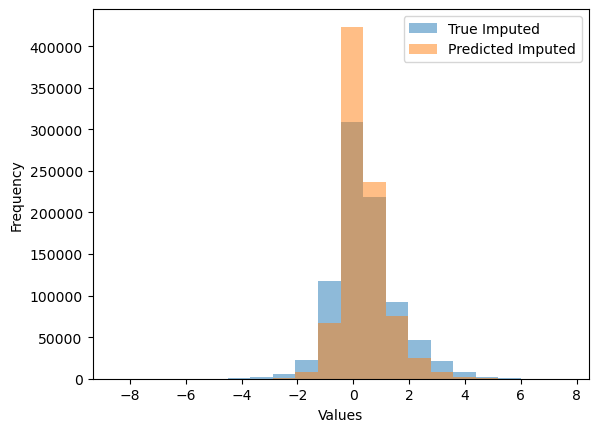

In [12]:
# Assuming t_reg_imputed and ctst_pred_reg_imputed are your imputed arrays
# Flatten and sample the data (every 20th element for plotting)
t_reg_imputed_flat = t_reg_imputed.flatten()[::20]
ctst_pred_reg_imputed_flat = ctst_pred_reg_imputed.flatten()[::20]

# Calculate the combined data for binning
combined_data = np.concatenate((t_reg_imputed_flat, ctst_pred_reg_imputed_flat))

# Calculate bin edges
num_bins = 20
bin_edges = np.histogram_bin_edges(combined_data, bins=num_bins)

# Plot histograms with the same bin edges
plt.hist(t_reg_imputed_flat, bins=bin_edges, alpha=0.5, label='True Imputed')
plt.hist(ctst_pred_reg_imputed_flat, bins=bin_edges, alpha=0.5, label='Predicted Imputed')

# Adding labels and legend
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

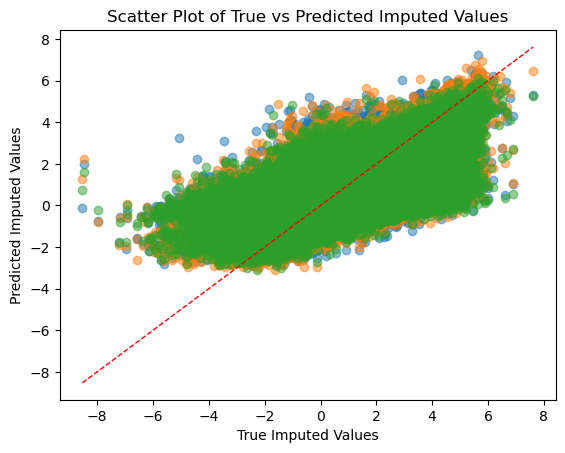

In [15]:
#and let's plot it on a scatter plot for ctst and mult
t_reg_imputed_flat = t_reg_imputed.flatten()
ctst_pred_reg_imputed_flat = ctst_pred_reg_imputed.flatten()
mult_pred_reg_imputed_flat = mult_pred_reg_imputed.flatten()
mult2_pred_reg_imputed_flat = mult2_pred_reg_imputed.flatten()

# Sample the data (every 20th element for plotting) if the data is too large
sample_indices = np.arange(0, len(t_reg_imputed_flat), 20)
t_reg_imputed_sampled = t_reg_imputed_flat[sample_indices]
ctst_pred_reg_imputed_sampled = ctst_pred_reg_imputed_flat[sample_indices]
mult_pred_reg_imputed_sampled = mult_pred_reg_imputed_flat[sample_indices]
mult2_pred_reg_imputed_sampled = mult2_pred_reg_imputed_flat[sample_indices]

# Create the scatter plot
plt.scatter(t_reg_imputed_sampled, ctst_pred_reg_imputed_sampled, alpha=0.5, label='ctst')
plt.scatter(t_reg_imputed_sampled, mult_pred_reg_imputed_sampled, alpha=0.5, label='mult')
plt.scatter(t_reg_imputed_sampled, mult2_pred_reg_imputed_sampled, alpha=0.5, label='mult2')
plt.xlabel('True Imputed Values')
plt.ylabel('Predicted Imputed Values')
plt.title('Scatter Plot of True vs Predicted Imputed Values')

# Adding a line y=x for reference
min_val = min(t_reg_imputed_sampled.min(), ctst_pred_reg_imputed_sampled.min())
max_val = max(t_reg_imputed_sampled.max(), ctst_pred_reg_imputed_sampled.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)
#huh, they're actually more identical than they first let off... that's not good!

Text(0.5, 1.0, 'multitasking model 2')

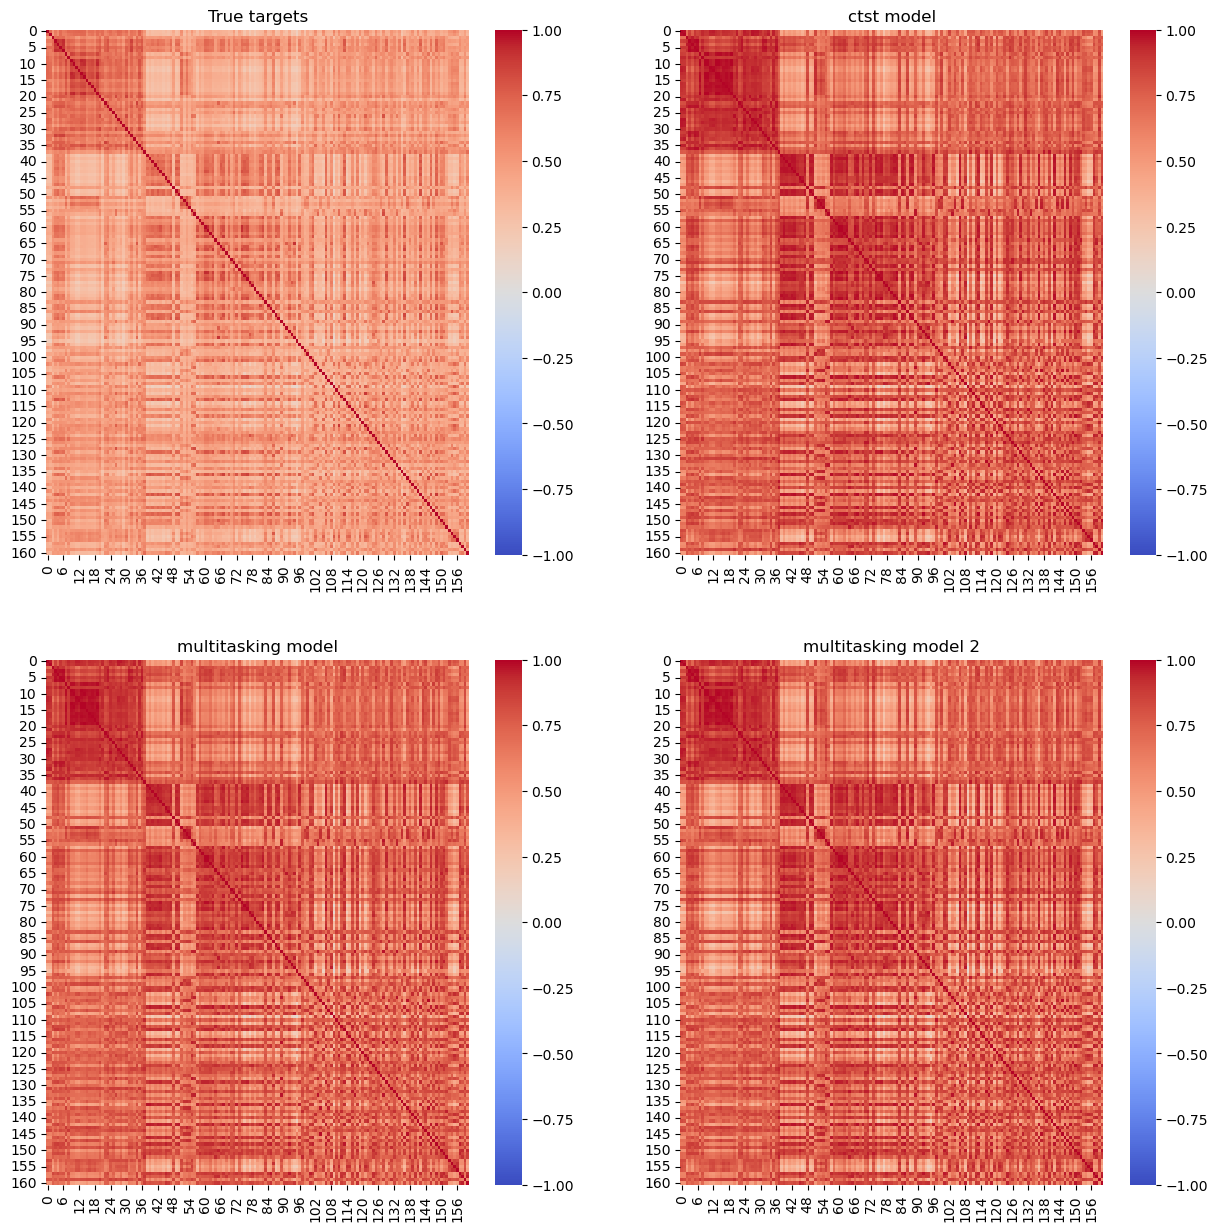

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
ctst_pred_reg_imputed = ctst_pred_reg.clone()
mult_pred_reg_imputed = mult_pred_reg.clone()
mult2_pred_reg_imputed = mult2_pred_reg.clone()
t_reg_imputed = t_reg.clone()
for i in range(t_reg.shape[0]):
    tempmask = t_reg[i, :] != -10
    ctst_pred_reg_imputed[i, ~tempmask] = ctst_pred_reg_imputed[i, tempmask].median() #impute the mean of the rest in that row
    mult_pred_reg_imputed[i, ~tempmask] = mult_pred_reg_imputed[i, tempmask].median() #impute the mean of the rest in that row
    mult2_pred_reg_imputed[i, ~tempmask] = mult2_pred_reg_imputed[i, tempmask].median() #impute the mean of the rest in that row
    t_reg_imputed[i, ~tempmask] = t_reg_imputed[i, tempmask].median() #impute the mean of the rest in that row

#now that it's imputed we don't mask just do the corrcoef
correlation_matrix_true = np.corrcoef(t_reg_imputed.numpy(), rowvar=False)
correlation_matrix_ctst = np.corrcoef(ctst_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult = np.corrcoef(mult_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult2 = np.corrcoef(mult2_pred_reg_imputed.numpy(), rowvar=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')


Text(0.5, 1.0, 'Violin Plot of Upper Triangle Correlation Values')

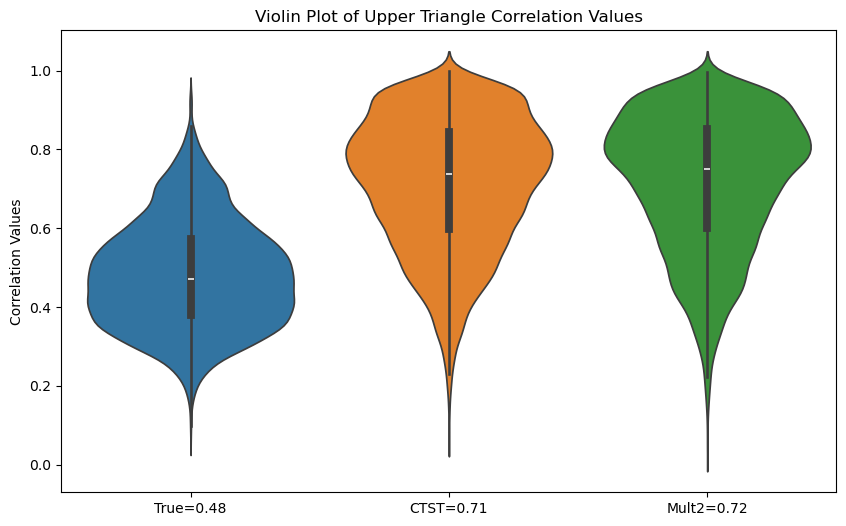

In [21]:
#let's do violinplot of the upper triangle values
def upper_triangle_values(correlation_matrix):
    upper_tri_indices = np.triu_indices_from(correlation_matrix, k=1)
    return correlation_matrix[upper_tri_indices]

# Extracting upper triangle values for each correlation matrix
values_true = upper_triangle_values(correlation_matrix_true)
values_ctst = upper_triangle_values(correlation_matrix_ctst)
values_mult = upper_triangle_values(correlation_matrix_mult)
values_mult2 = upper_triangle_values(correlation_matrix_mult2)

# Prepare data for violin plot
data = [
    values_true,
    values_ctst,
    # values_mult,
    values_mult2
]

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
# names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult={np.mean(values_mult):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
plt.xticks([0, 1, 2], names)
plt.ylabel('Correlation Values')
plt.title('Violin Plot of Upper Triangle Correlation Values')

Text(0.5, 1.0, 'multitasking model 2')

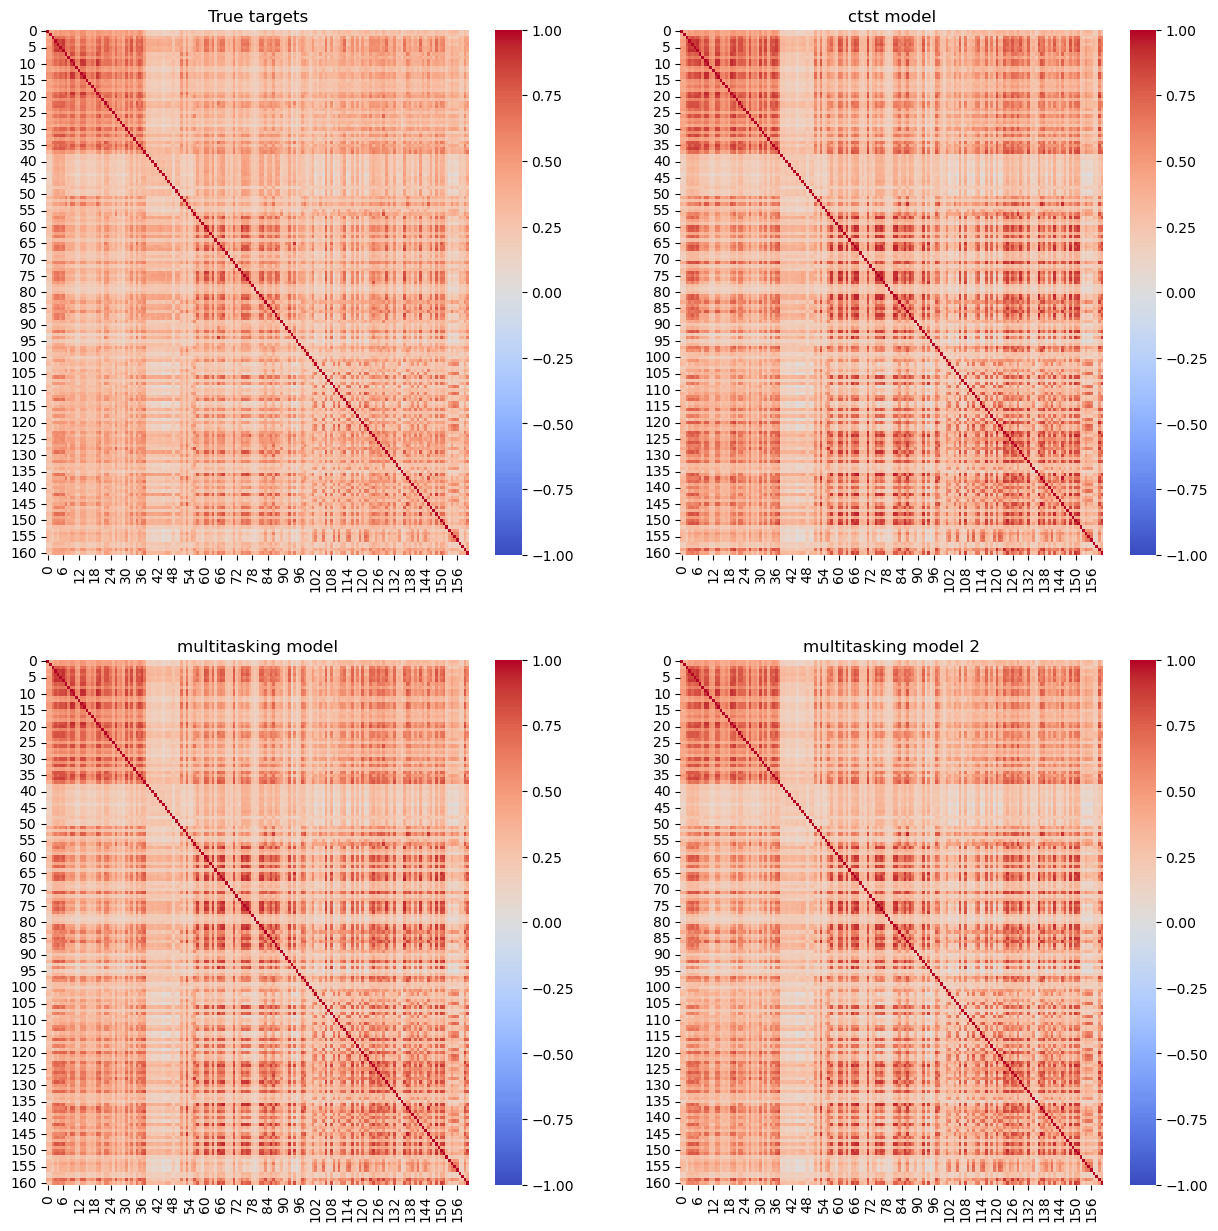

In [22]:
#finally let's impute -10

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
ctst_pred_reg_imputed = ctst_pred_reg.clone()
mult_pred_reg_imputed = mult_pred_reg.clone()
mult2_pred_reg_imputed = mult2_pred_reg.clone()
t_reg_imputed = t_reg.clone()
for i in range(t_reg.shape[0]):
    tempmask = t_reg[i, :] != -10
    ctst_pred_reg_imputed[i, ~tempmask] = -10 #impute the mean of the rest in that row
    mult_pred_reg_imputed[i, ~tempmask] = -10 #impute the mean of the rest in that row
    mult2_pred_reg_imputed[i, ~tempmask] = -10 #impute the mean of the rest in that row
    t_reg_imputed[i, ~tempmask] = -10 #impute the mean of the rest in that row

#now that it's imputed we don't mask just do the corrcoef
correlation_matrix_true = np.corrcoef(t_reg_imputed.numpy(), rowvar=False)
correlation_matrix_ctst = np.corrcoef(ctst_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult = np.corrcoef(mult_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult2 = np.corrcoef(mult2_pred_reg_imputed.numpy(), rowvar=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')


Text(0.5, 1.0, 'Violin Plot of Upper Triangle Correlation Values')

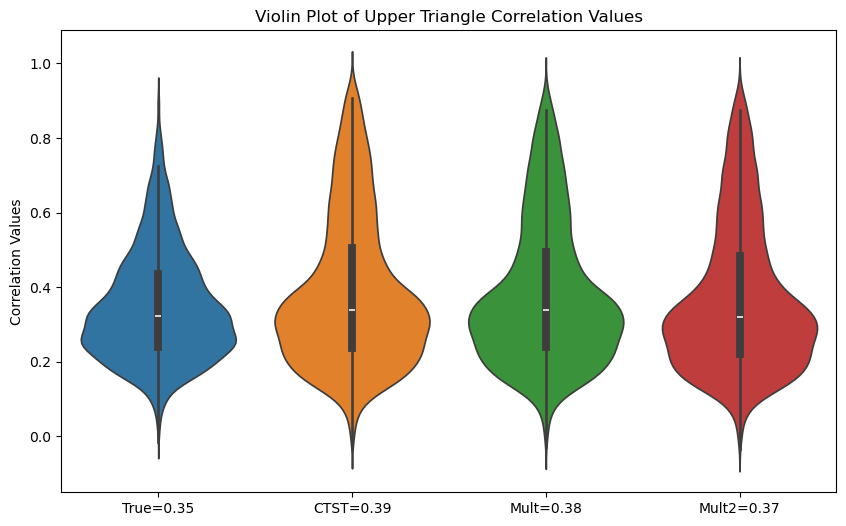

In [25]:
#let's do violinplot of the upper triangle values
def upper_triangle_values(correlation_matrix):
    upper_tri_indices = np.triu_indices_from(correlation_matrix, k=1)
    return correlation_matrix[upper_tri_indices]

# Extracting upper triangle values for each correlation matrix
values_true = upper_triangle_values(correlation_matrix_true)
values_ctst = upper_triangle_values(correlation_matrix_ctst)
values_mult = upper_triangle_values(correlation_matrix_mult)
values_mult2 = upper_triangle_values(correlation_matrix_mult2)

# Prepare data for violin plot
data = [
    values_true,
    values_ctst,
    values_mult,
    values_mult2
]

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult={np.mean(values_mult):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
# names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
plt.xticks([0, 1, 2, 3], names)
plt.ylabel('Correlation Values')
plt.title('Violin Plot of Upper Triangle Correlation Values')

Text(0.5, 1.0, 'multitasking model 2')

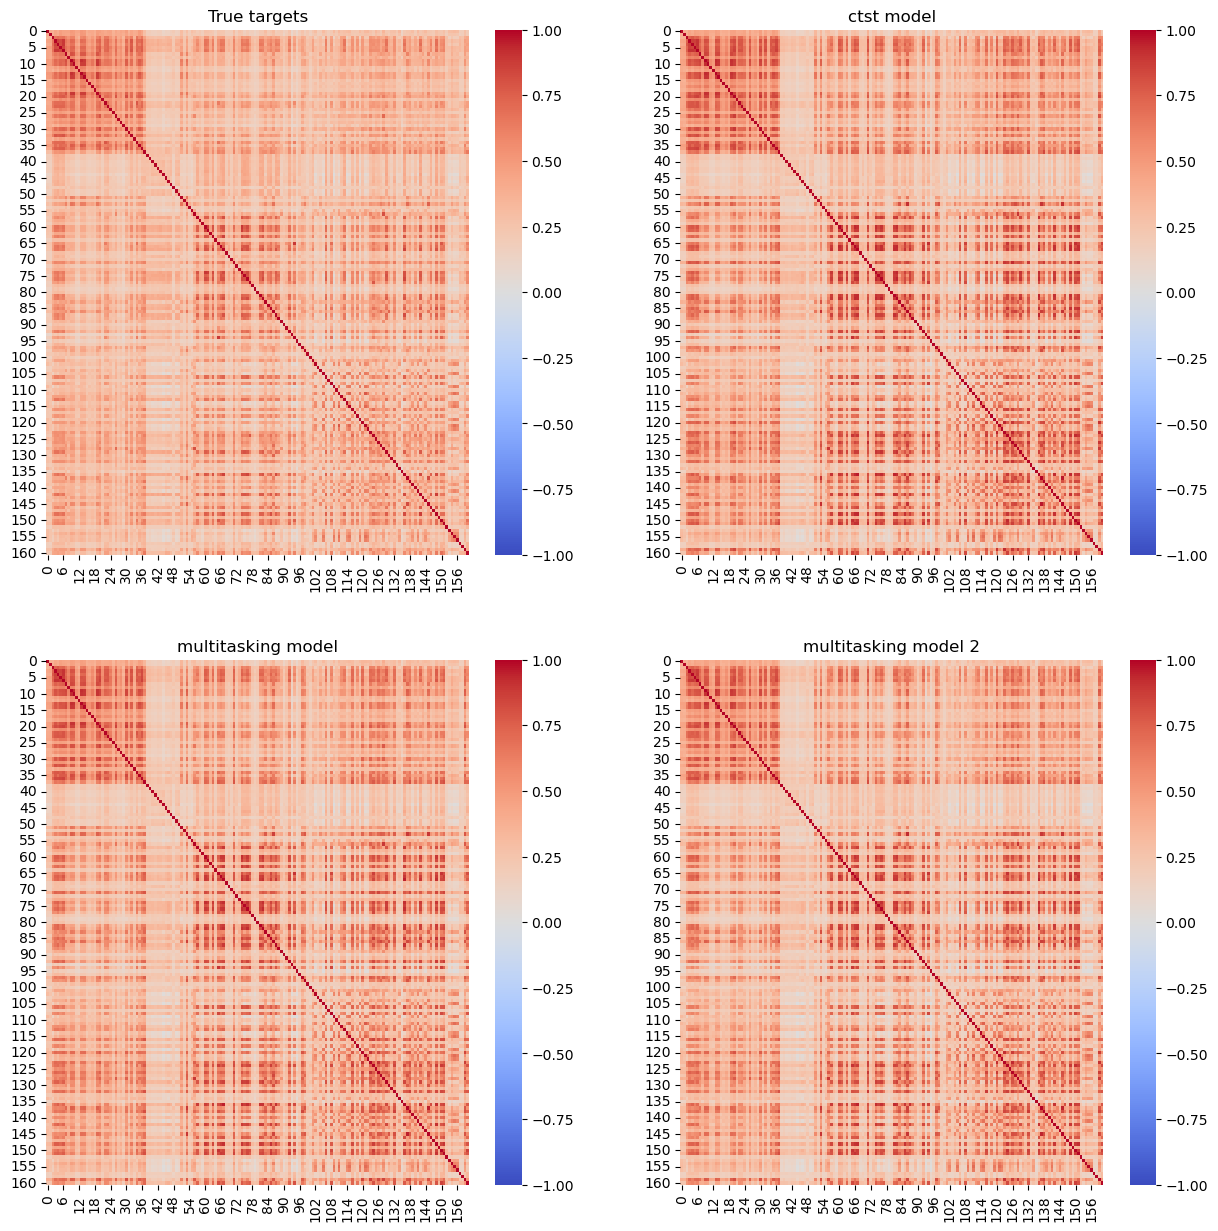

In [28]:
#finally it doesn't actually want to do the mean, and -10 isn't great, but let's try to test this with some random values

ctst_pred_reg_imputed = ctst_pred_reg.clone()
mult_pred_reg_imputed = mult_pred_reg.clone()
mult2_pred_reg_imputed = mult2_pred_reg.clone()
t_reg_imputed = t_reg.clone()
for i in range(t_reg.shape[0]):
    tempmask = t_reg[i, :] != -10
    #now select a value with a normal distribution centered at -10
    imputed_val = np.random.normal(-10, 5)
    ctst_pred_reg_imputed[i, ~tempmask] = imputed_val #impute the mean of the rest in that row
    mult_pred_reg_imputed[i, ~tempmask] = imputed_val #impute the mean of the rest in that row
    mult2_pred_reg_imputed[i, ~tempmask] = imputed_val #impute the mean of the rest in that row
    t_reg_imputed[i, ~tempmask] = imputed_val #impute the mean of the rest in that row

correlation_matrix_true = np.corrcoef(t_reg_imputed.numpy(), rowvar=False)
correlation_matrix_ctst = np.corrcoef(ctst_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult = np.corrcoef(mult_pred_reg_imputed.numpy(), rowvar=False)
correlation_matrix_mult2 = np.corrcoef(mult2_pred_reg_imputed.numpy(), rowvar=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
sns.heatmap(correlation_matrix_true, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 0])
axs[0, 0].set_title('True targets')
sns.heatmap(correlation_matrix_ctst, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[0, 1])
axs[0, 1].set_title('ctst model')
sns.heatmap(correlation_matrix_mult, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 0])
axs[1, 0].set_title('multitasking model')
sns.heatmap(correlation_matrix_mult2, cmap='coolwarm', vmin=-1, vmax=1, ax=axs[1, 1])
axs[1, 1].set_title('multitasking model 2')


Text(0.5, 1.0, 'Violin Plot of Upper Triangle Correlation Values')

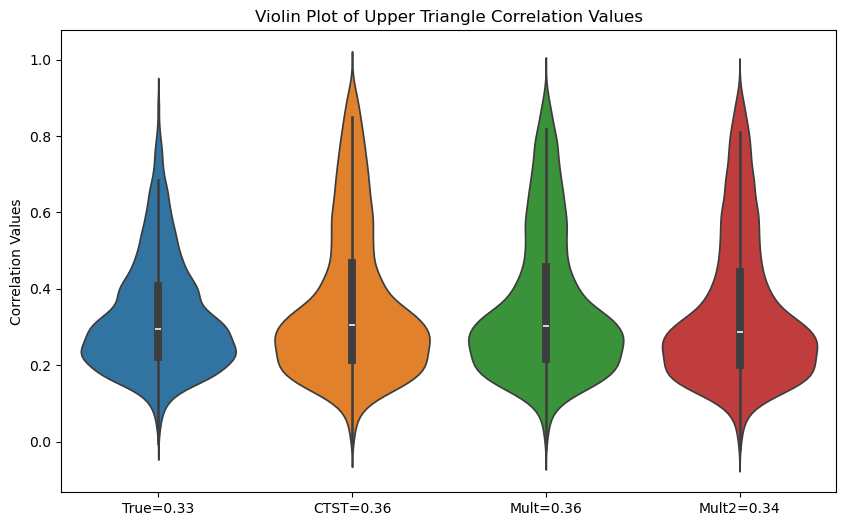

In [29]:
#let's do violinplot of the upper triangle values
def upper_triangle_values(correlation_matrix):
    upper_tri_indices = np.triu_indices_from(correlation_matrix, k=1)
    return correlation_matrix[upper_tri_indices]

# Extracting upper triangle values for each correlation matrix
values_true = upper_triangle_values(correlation_matrix_true)
values_ctst = upper_triangle_values(correlation_matrix_ctst)
values_mult = upper_triangle_values(correlation_matrix_mult)
values_mult2 = upper_triangle_values(correlation_matrix_mult2)

# Prepare data for violin plot
data = [
    values_true,
    values_ctst,
    values_mult,
    values_mult2
]

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=data)
names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult={np.mean(values_mult):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
# names = [f'True={np.mean(values_true):.2f}', f'CTST={np.mean(values_ctst):.2f}', f'Mult2={np.mean(values_mult2):.2f}']
plt.xticks([0, 1, 2, 3], names)
plt.ylabel('Correlation Values')
plt.title('Violin Plot of Upper Triangle Correlation Values')

In [ ]:
#so this isn't good, but the reason it isn't good is because of a few reasons
#one, the worst model has the lowest correlation, primarily because we actually see that one doesn't predict negatives as well
#so then having negatives makes it work like that
#but because never tasked with it, never trained on it
#shows that we basically cannot use this model to prove it works, but likely it is promising
#have to use immgen

## SPI1 heatmap

In [ ]:
#let's go aheaad and just create the proper accessibility matrix since we'll need that for sure

#let's produce a figure quality heatmap comparing the models, then we can show these examples to show how it doesn't capture known motifs for B cells: SPI1
#we'll look at the GATA ones again
#let's try GATA 3
#let's load our saved file
import numpy as np
load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_summary_bothmodel.npz')
fimo_summary,fimo_summary_mult = load['fimo_summary'], load['fimo_summary_mult']
print(fimo_summary.shape, fimo_summary_mult.shape)
import matplotlib.pyplot as plt
import seaborn as sns
#it is based on elements of train_idx, so to figure it out, load in train idx
#now let's plot it
from shap_analysis.ism_utils import *
multitasking_path1 = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-27/18-39-11-031863/checkpoints/25-val_loss=0.52186.ckpt' #the 25 epoch one
ctst_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-25/15-41-13-286486/checkpoints/last.ckpt'
mult = ISMUtils('DNase_allcelltypes', multitasking_path1, classification=True)
ctst = ISMUtils('DNase_ctst', ctst_path, classification=True)
mult_val = ISMUtils('DNase_allcelltypes', multitasking_path1, classification=True, split='val')
mult_test = ISMUtils('DNase_allcelltypes', multitasking_path1, classification=True, split='test')
#now have to load in the datafram to see where it is!
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train_idx.npy')
val_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/val_idx.npy')
test_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/test_idx.npy')

#remove the 752763 index from train_idx
train_idx = train_idx[train_idx != 752763]

import polars as pl
fimo_results = pl.read_csv('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_motifs/fimo.tsv', separator = '\t')

fimo_results = fimo_results.drop(['motif_alt_id', 'string'])
fimo_results = fimo_results[:-3]

extra_pad = 5
all_motifs = fimo_results.group_by('motif_id').agg().sort('motif_id')
all_motifs = all_motifs.to_numpy()
motif_dict = {}
counter = 0
for motif in all_motifs:
    motif_dict[motif[0]] = counter
    counter += 1

(9999, 572, 161) (9999, 572, 161)


(544, 161) (544, 161) (544, 161)


Text(0.5, 1.0, 'accessibility')

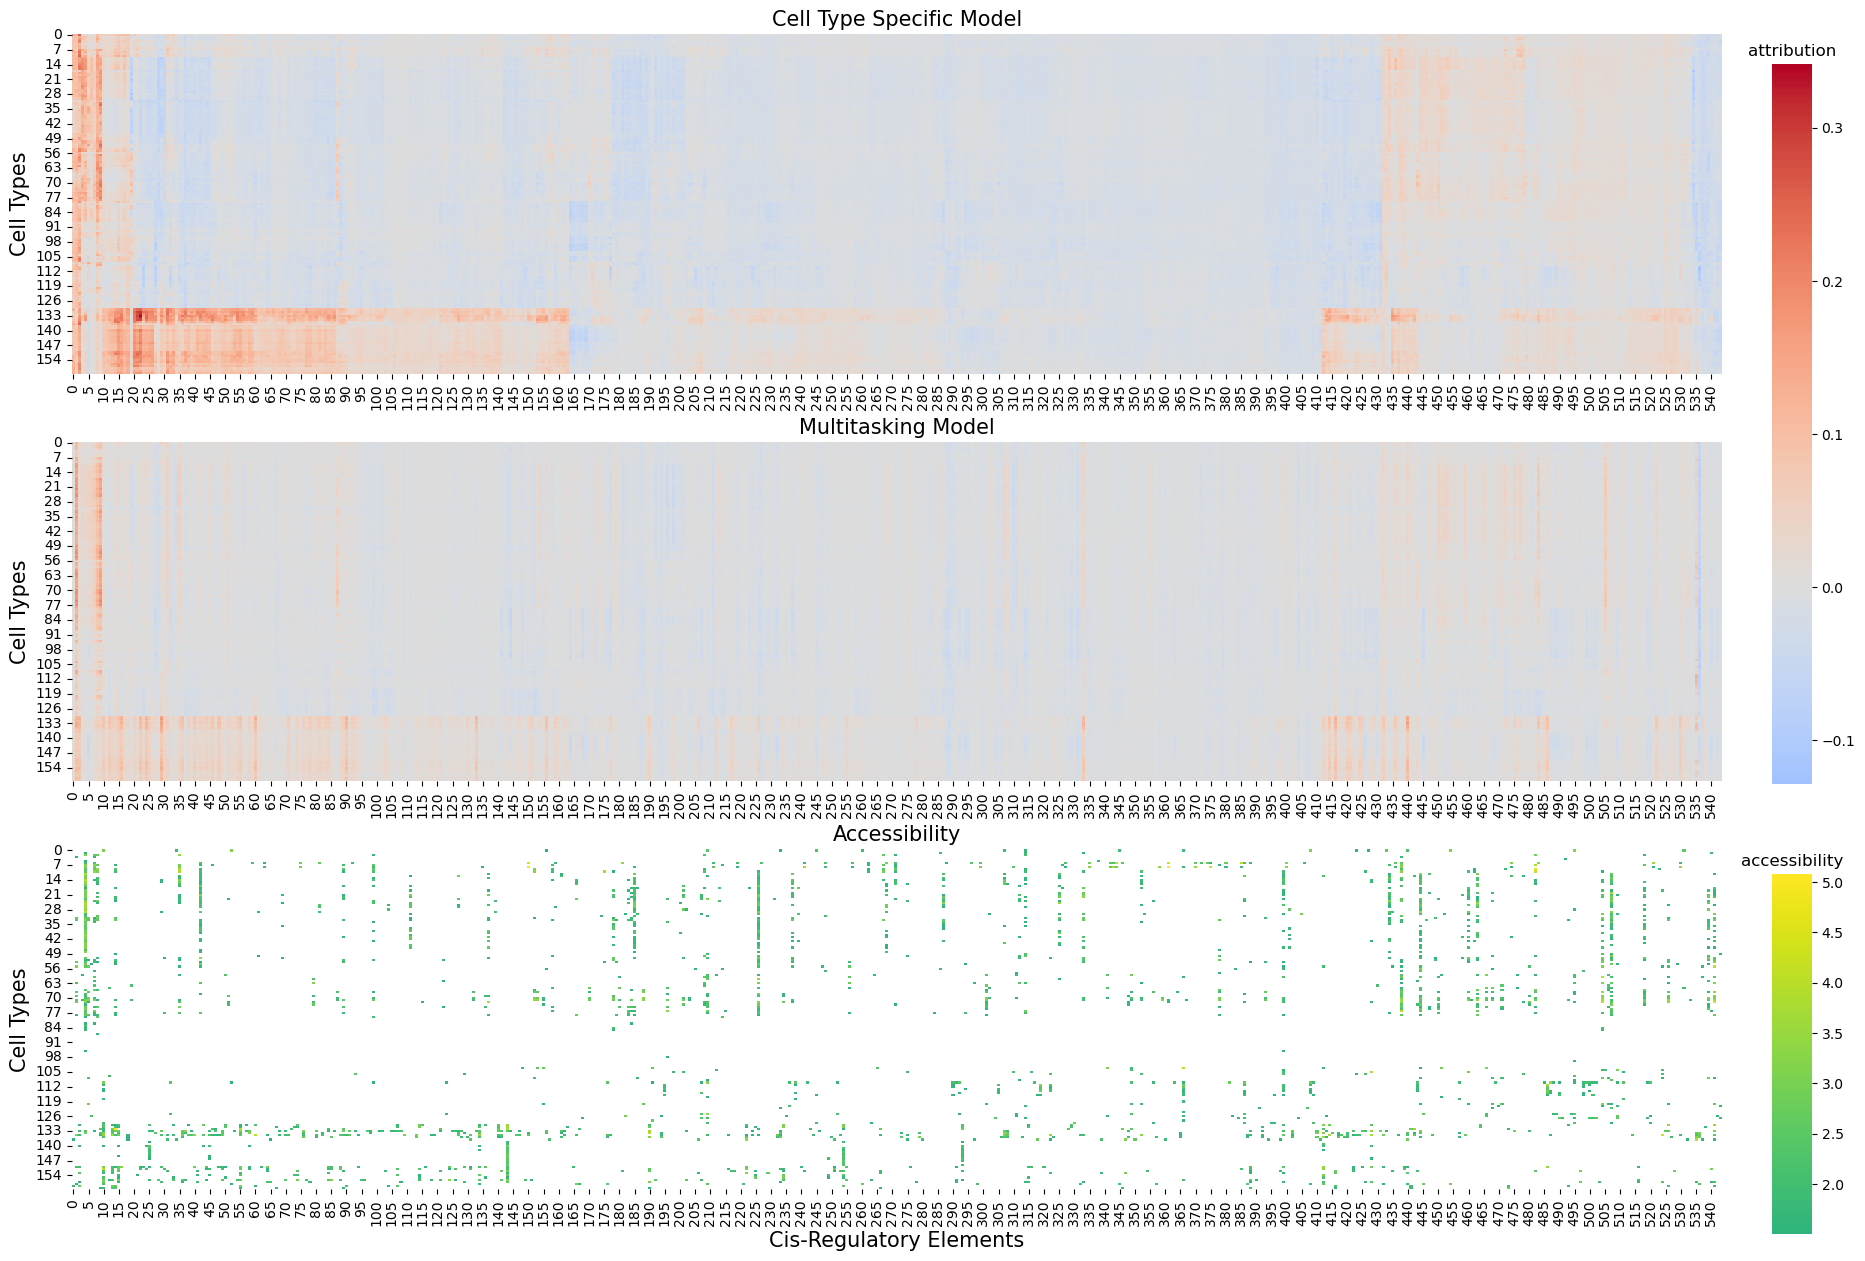

In [ ]:
#have to order the rows still, but we can do that later
#we need the second mask that we define with keep indices
#now we have it properly!!

temp = fimo_summary[:,466,:]
temp2 = fimo_summary_mult[:,466,:]
full_idxs = np.concatenate((train_idx,val_idx,test_idx))

mask = np.abs(temp).sum(1) > 1.5
temp = temp[mask]
temp2 = temp2[mask]
g = sns.clustermap(-temp.T,cmap='coolwarm', center=0, figsize=(20,8))
plt.close()
col_order = g.dendrogram_col.reordered_ind
row_order = g.dendrogram_row.reordered_ind
remove_indices = np.array(col_order)[295:745]
keep_indices = np.array(col_order)[np.setdiff1d(np.arange(len(col_order)),remove_indices)]

maskedresult = full_idxs[mask]
ordered_result = maskedresult[keep_indices]
accessibility = np.zeros((keep_indices.shape[0], 161), dtype=np.float32)
for i, idx in enumerate((ordered_result)):
    # idx = int(idx[0])
    labels = mult.dataset[idx][1][1]
    accessibility[i] = labels
accessibility[289] = mult_test.dataset[61086][1][1]

newtemp = temp[keep_indices]
newtemp = newtemp[:,row_order]
fig,ax = plt.subplots(3,1,figsize=(20,15))
newtemp2 = temp2[keep_indices]
newtemp2 = newtemp2[:,row_order]
vmax = -min(newtemp.min(), newtemp2.min())
vmin = -max(newtemp.max(), newtemp2.max())
newaccessibility = accessibility[:,row_order]
newaccessibility = accessibility[:,row_order]
print(newtemp.shape, newtemp2.shape, newaccessibility.shape)
sns.heatmap(-newtemp.T,cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, ax = ax[0], cbar=None)
plt.subplots_adjust(right=.95)
cbar_ax = fig.add_axes([0.975, 0.38, .02, 0.48])
cbar_ax2 = fig.add_axes([0.975, 0.08, .02, 0.24])
sns.heatmap(-newtemp2.T,cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, ax = ax[1], cbar_ax = cbar_ax)
sns.heatmap(newaccessibility.T,cmap='viridis', center=0, ax = ax[2], cbar_ax=cbar_ax2, mask = newaccessibility.T<1.5)

#now let's label the x and y axes
fontsize = 15
ax[0].set_ylabel('Cell Types', fontsize=fontsize)
ax[1].set_ylabel('Cell Types',fontsize=fontsize)
ax[2].set_ylabel('Cell Types',fontsize=fontsize)
ax[2].set_xlabel('Cis-Regulatory Elements',fontsize=fontsize)
#and set the titles
ax[0].set_title('Cell Type Specific Model',fontsize=fontsize)
ax[1].set_title('Multitasking Model',fontsize=fontsize)
ax[2].set_title('Accessibility',fontsize=fontsize)
cbar_ax.set_title('attribution')
cbar_ax2.set_title('accessibility')

## Chip seq plot

In [1]:
#let's redo it all, the goal again is to recreate the above but proper!
import os
import pandas as pd
import polars as pl

ccre_df = pl.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', separator='\t', has_header = False)
ccre_to_index = {}
for i in range(len(ccre_df)):
    ccre_id = ccre_df[i,3]
    ccre_to_index[ccre_id] = i

import numpy as np
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/train_idx.npy')
val_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/val_idx.npy')
test_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs2/test_idx.npy')

train_idx = train_idx[train_idx != 752763]

ccre_ids = []
data_path = f'/data/leslie/sarthak/data/train.csv'
array = pd.read_csv(data_path).to_numpy() #note this works because we have a header in the csv
for idx in train_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/val.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in val_idx:
    ccre_ids.append(array[idx,0])
data_path = '/data/leslie/sarthak/data/test.csv'
array = pd.read_csv(data_path).to_numpy()
for idx in test_idx:
    ccre_ids.append(array[idx,0])

highvar_ccre_id_to_idx = {}
for i in range(len(ccre_ids)):
    highvar_ccre_id_to_idx[ccre_ids[i]] = i

ccre_row = []
for idx in ccre_ids:
    ccre_row.append(ccre_to_index[idx])
highly_variable_df = ccre_df[np.array(ccre_row),:]
headers_highvar = ['chr','start','stop','id1','id2','type']
highly_variable_df.columns = headers_highvar

#now index into fimo_summary with this information
load = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/fimo_summary_bothmodel.npz')
fimo_summary,fimo_summary_mult = load['fimo_summary'], load['fimo_summary_mult']
spi1 = fimo_summary[:,466,:]
spi1_mult = fimo_summary_mult[:,466,:]
print(spi1.shape)

(9999, 161)


In [2]:
#wait, we have been doing it form the start, but it should be between the start and end!!
#let's just try 200
#we can literally just make a list of this for the k562 cell!!
#and then do a for loop, but let's make this for the k562 cell first
from tqdm import tqdm
all_list = []
mydir = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/ENCODE_chip/'
headers = ['chr','start','stop','name','score','strand','signal','pval','qval','peak point']
for file in sorted(os.listdir(mydir)):
    if not file.endswith('.bed'):
        continue
    df = pl.read_csv(mydir+file, separator = '\t', has_header=False, new_columns=headers)
    print(file)
    celltype_list = []
    for tf_peak in tqdm(range(len(df)), total = len(df)):
        peak = df[tf_peak,:]
        peak_start = peak['start'][0]
        peak_end = peak['stop'][0]
        peak_middle = (peak_start+peak_end)//2
        chromosome = peak['chr'][0]
        subset_df = highly_variable_df.filter(highly_variable_df['chr']==chromosome).sort('start')
        middle = (subset_df['start'].to_numpy() + subset_df['stop'].to_numpy()) // 2
        middle = middle-peak_middle
        # close = np.abs(start)<500
        close = np.abs(middle)<300
        locations = np.where(close)[0] #provides all the locations
        if len(locations)==0: #if there's no locations we don't care
            continue
        #else we index back into the dataframe, grab the index and chromosome, that will tell us which index and chromosome it is!!
        newdf = subset_df[locations,:]
        for i in range(len(newdf)):
            celltype_list.append(newdf['id1'][i])
    all_list.append(celltype_list)
# print(len(k562_list))

GM12878.bed


  6%|▌         | 2586/44283 [00:01<00:26, 1563.80it/s]

100%|██████████| 44283/44283 [00:28<00:00, 1544.33it/s]


GM12891.bed


100%|██████████| 54271/54271 [00:35<00:00, 1550.52it/s]


HL60.bed


100%|██████████| 63379/63379 [00:40<00:00, 1548.95it/s]


K562.bed


100%|██████████| 32606/32606 [00:21<00:00, 1552.28it/s]


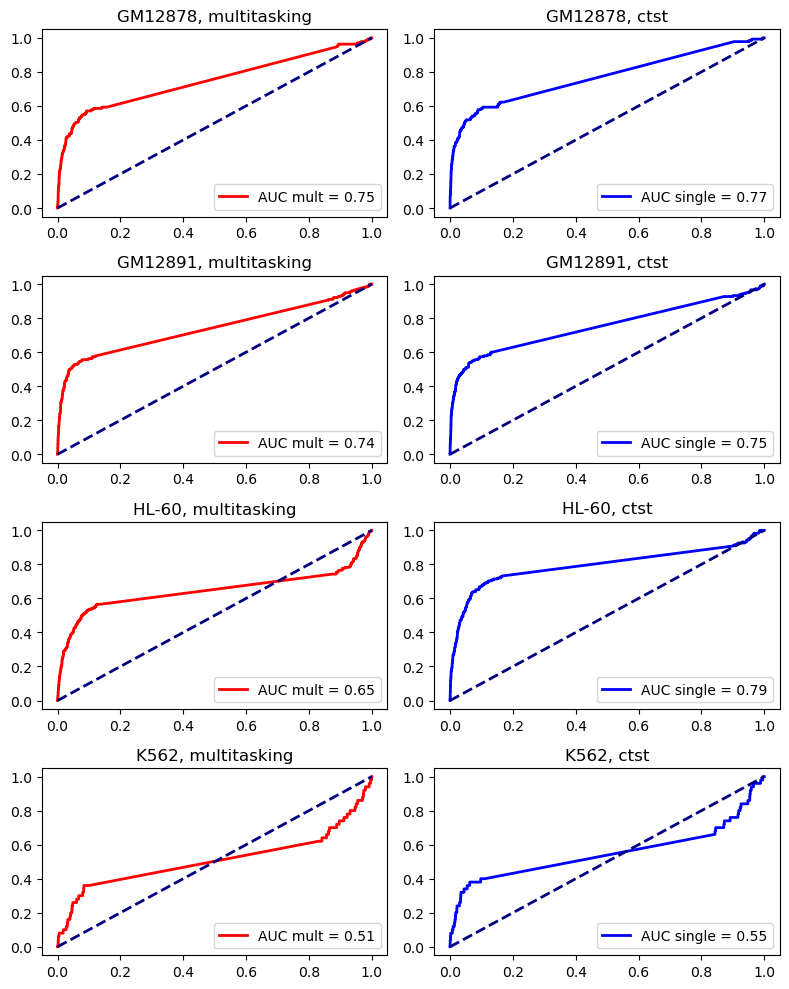

In [ ]:
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    fpr, tpr, _ = roc_curve(labels, full_vector)
    roc_auc = roc_auc_score(labels, full_vector)
    fpr_mult, tpr_mult, _ = roc_curve(labels, full_vector_mult)
    roc_auc_mult = roc_auc_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC single = {roc_auc:.2f}')
    ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="lower right")

    ax[row, 0].plot(fpr_mult, tpr_mult, color='red', lw=2, label=f'AUC mult = {roc_auc_mult:.2f}')
    ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="lower right")

# Adjust layout
fig.tight_layout()
plt.show()
    

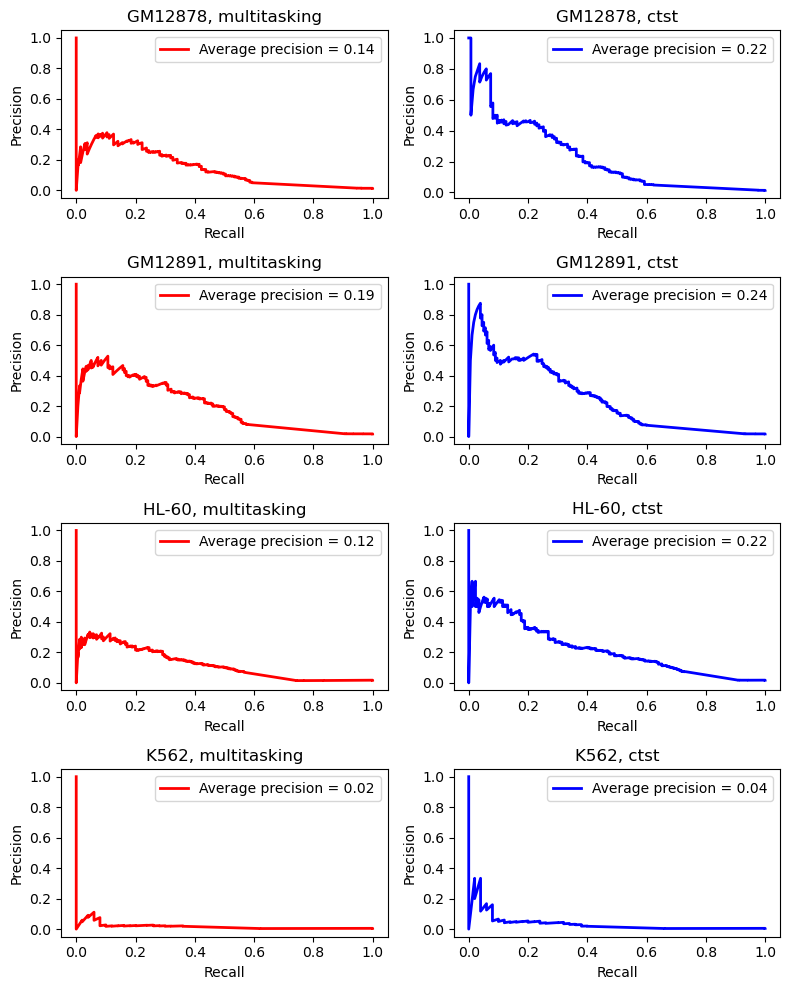

In [ ]:
#now the real task is calculating the prc
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
#let's do a 4x2 subplot where we actually go through and do this for all the celltypes
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,2,figsize=(8,10))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row, 1].plot(recall,precision, color='blue', lw=2, label=f'Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 1].set_title(f'{name_list[idx]}, ctst')
    ax[row, 1].legend(loc="upper right")
    ax[row, 1].set_xlabel('Recall')
    ax[row, 1].set_ylabel('Precision')

    ax[row, 0].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Average precision = {roc_auc_mult:.2f}')
    # ax[row, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row, 0].set_title(f'{name_list[idx]}, multitasking')
    ax[row, 0].legend(loc="upper right")
    ax[row, 0].set_xlabel('Recall')
    ax[row, 0].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

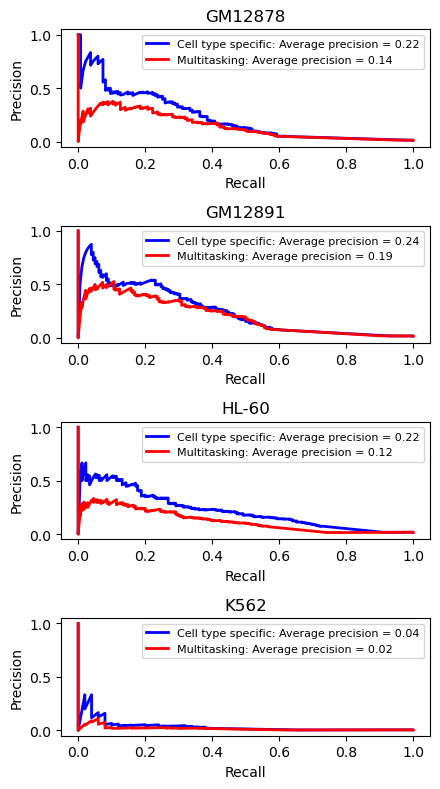

In [9]:
#we'll do the AUPR plot but make it paired to save space
#now the real task is calculating the prc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
celltypes_idx = [54,11,154,83]
name_list = ['GM12878', 'GM12891', 'HL-60', 'K562']
fig,ax = plt.subplots(4,1,figsize=(4.5,8))
for idx, cell in enumerate(celltypes_idx):
    names_list = np.array(all_list[idx])
    label_list = []
    for name in names_list:
        label_list.append(highvar_ccre_id_to_idx[name])
    temp_labels = np.array(label_list)
    full_vector = -fimo_summary[:,466,cell]
    full_vector_mult = -fimo_summary_mult[:,466,cell]
    labels = np.zeros_like(full_vector)
    labels[temp_labels] = 1

    precision,recall,_ = precision_recall_curve(labels, full_vector)

    roc_auc = average_precision_score(labels, full_vector)
    precision_mult,recall_mult, _ = precision_recall_curve(labels, full_vector_mult)
    roc_auc_mult = average_precision_score(labels, full_vector_mult)

    row = idx

    # Plot ROC curves
    ax[row].plot(recall,precision, color='blue', lw=2, label=f'Cell type specific: Average precision = {roc_auc:.2f}')
    # ax[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # ax[row].set_title(f'{name_list[idx]}, ctst')
    # ax[row].legend(loc="upper right")
    ax[row].set_xlabel('Recall')
    ax[row].set_ylabel('Precision')

    ax[row].plot(recall_mult, precision_mult, color='red', lw=2, label=f'Multitasking: Average precision = {roc_auc_mult:.2f}')
    # ax[row].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[row].set_title(f'{name_list[idx]}')
    ax[row].legend(loc="upper right", fontsize=8)
    ax[row].set_xlabel('Recall')
    ax[row].set_ylabel('Precision')

# Adjust layout
fig.tight_layout()
plt.show()

## TFModisco

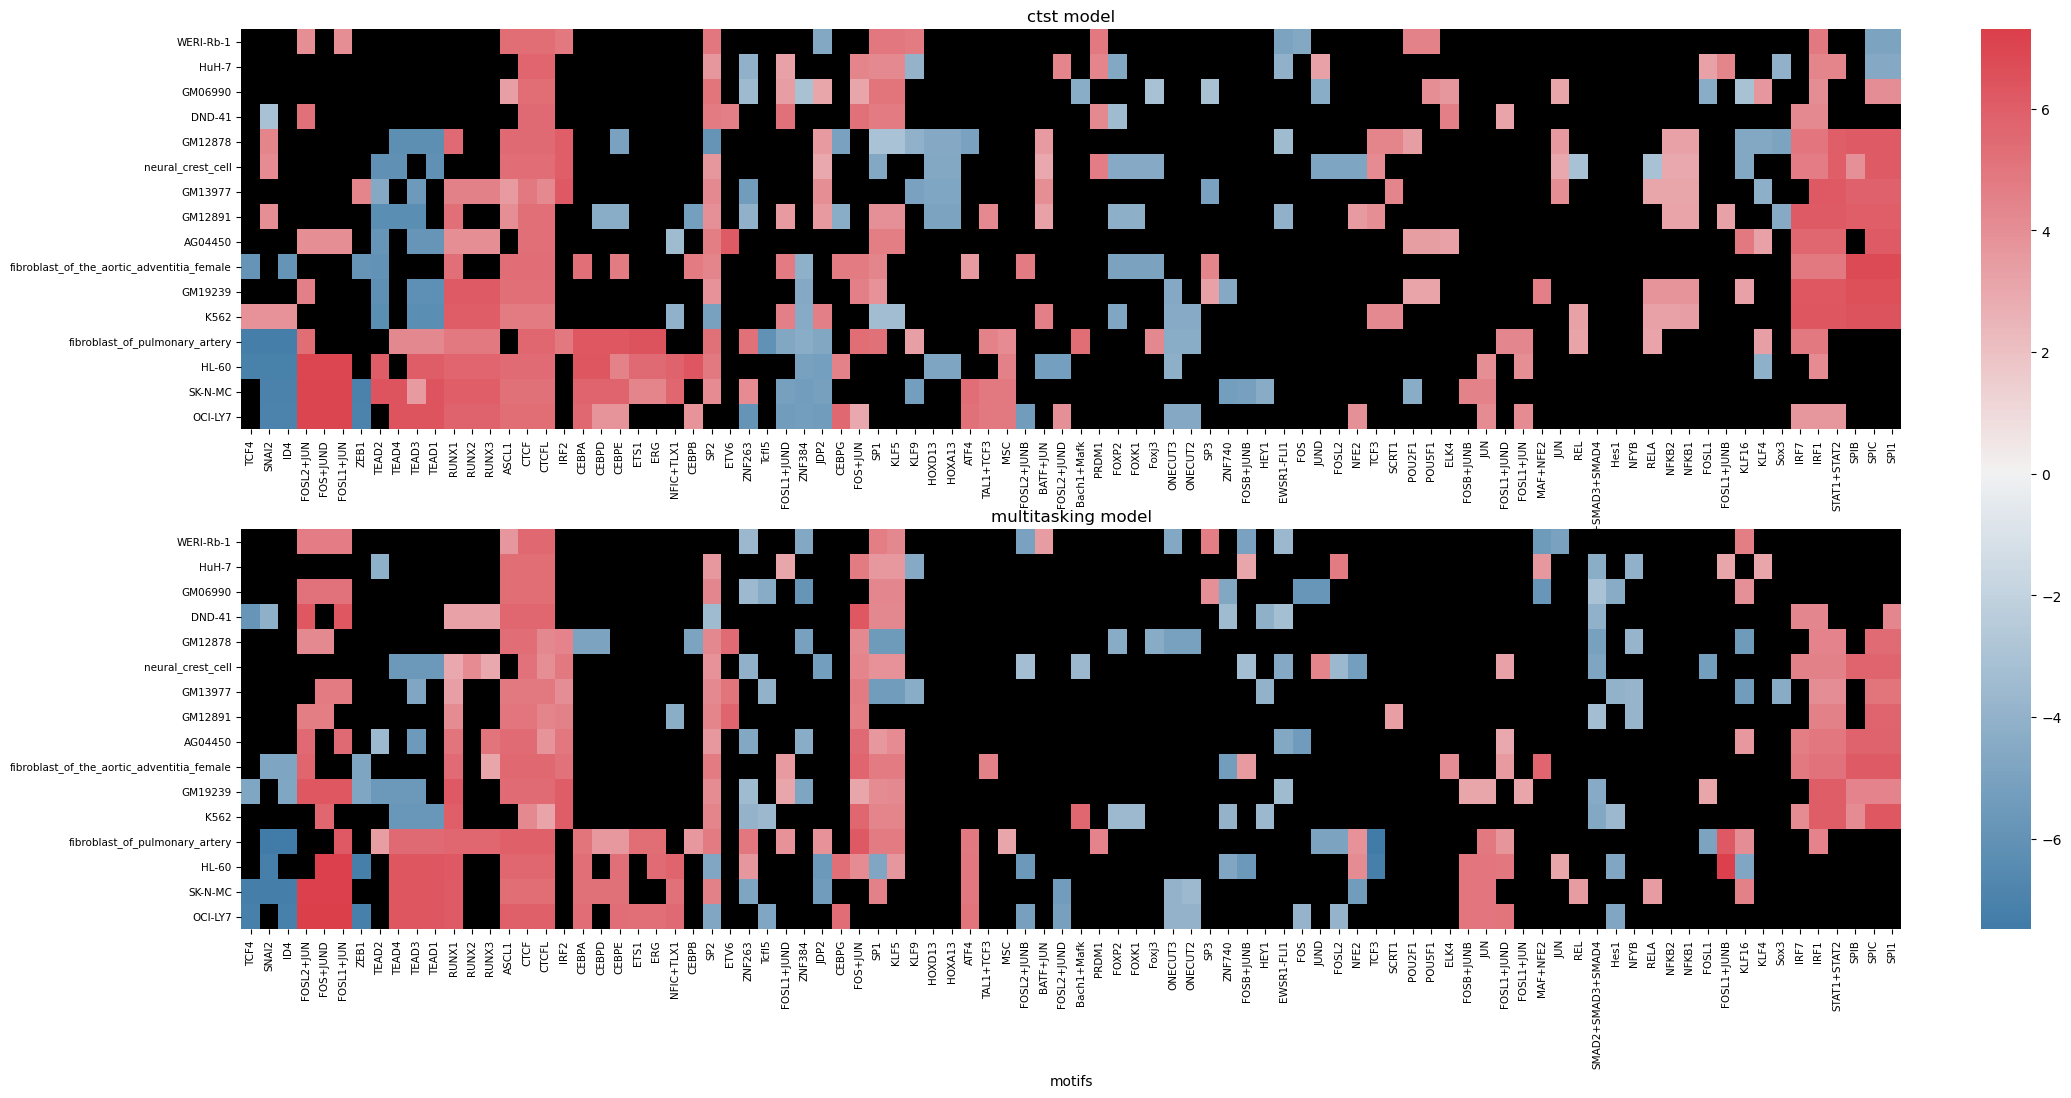

In [ ]:
#let's make same celltypes as seen in the FIMO analysis!!
#we need to account for removing the nans and removing the repeats keeping only the smallest q value!
qvals_threshold = .15
import re
import os
import pandas as pd
import numpy as np
directory = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/all_celltypes/reports/'
dict_value = 0
match_dict = {}
seqlets_list = []
seqlets_list_ctst = []
qvals_list = []
qvals_list_ctst = []
match_list = []
match_list_ctst = []

def numerical_sort(value): #this is a regex that uses the actual numbers to sort like 99 is before 100, but sorted(dir) does ls type sorting
    """Extracts numbers from a filename for sorting."""
    numbers = re.compile(r'(\d+)')  # Compiles a regex to find numbers
    parts = numbers.split(value)    # Splits the filename at each number
    parts[1::2] = map(int, parts[1::2])  # Converts all numeric strings to integers
    return parts

sorted_files = sorted(os.listdir(directory), key=numerical_sort)



for subdir in sorted_files:
    #first we go through the list of all the files, whether it's multitasking or ctst
    #these are the tfmodisco results
    # print(subdir) #does indeed print it in the ls order, so we need to chagne this
    # continue
    tables = pd.read_html(directory+subdir+'/'+'motifs.html')
    df = tables[0]
    #then we read in the html file and make it a table
    
    #now what we do is create
    qvals = pd.concat([df['qval0'],df['qval1'],df['qval2']], axis=0).to_numpy()
    matches = pd.concat([df['match0'],df['match1'],df['match2']], axis=0).to_numpy()
    seqs = pd.concat([df['num_seqlets'],df['num_seqlets'],df['num_seqlets']], axis=0).to_numpy()
    posneg = pd.concat([df['pattern'],df['pattern'],df['pattern']], axis=0).to_numpy()
    new_df = pd.DataFrame({
        'qvals': pd.concat([df['qval0'], df['qval1'], df['qval2']]),
        'matches': pd.concat([df['match0'], df['match1'], df['match2']]),
        'seqs': pd.concat([df['num_seqlets'], df['num_seqlets'], df['num_seqlets']]),  # Assuming repetition is intended
        'posneg': pd.concat([df['pattern'], df['pattern'], df['pattern']])  # Assuming repetition is intended
    })
    new_df.reset_index(drop=True, inplace=True)

    #now we filter out the low q values
    new_df = new_df[new_df['qvals'] < qvals_threshold]
    #and drop any rows that have an nan
    new_df = new_df.dropna()
    #and we change posneg to actually be positive oro negative
    new_df['posneg'] = new_df['posneg'].apply(lambda x: 1 if x.startswith('pos') else -1)
    #finally we sort it and drop duplicates based on the q value
    new_df = new_df.sort_values(by='qvals').drop_duplicates(subset='matches', keep='first')
    newmatch = new_df['matches'].to_numpy()
    newq = new_df['qvals'].to_numpy()
    newseqs = new_df['seqs'].to_numpy()
    posneg = new_df['posneg'].to_numpy()

    #now let's do this same check
    if len(np.unique(newmatch)) < len(newmatch):
        print('ERRRORRRRRRRR')

    for match in newmatch: #basically for each element, if it's not somethign new, we add it to the dictionary
        if match not in match_dict:
            match_dict[match] = dict_value
            dict_value += 1
    if 'mult' in subdir: #now if it' smultitasking, we append them all to the multitasking value
        match_list.append(newmatch) #now store it as a list of lists, where the element corresponding to this cre
        qvals_list.append(newq * posneg) #multiply by posneg to make it negative if it's a negative peak
        seqlets_list.append(newseqs * posneg) #multiply by posneg to make it negative if it's a negative peak
    elif 'ctst' in subdir:
        match_list_ctst.append(newmatch)
        qvals_list_ctst.append(newq * posneg)
        seqlets_list_ctst.append(newseqs * posneg)
    else:
        print('error')
        break
#still jsut a few seconds! This is great!!

full_array = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_ctst = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets_ctst = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
#now we go through all the different qvals_list which is actually just 160
for cell_idx in range(len(qvals_list)): #basically just go through each celltype!
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list[cell_idx]): #now go through the keys which is the motif name for each match in that celltype
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match] #here we find the index of the match in the dictionary
        full_array[match_idx, cell_idx] = qvals_list[cell_idx][counter] #now asign via motif number and celltype based on the celltype we have!
        full_array_seqlets[match_idx, cell_idx] = seqlets_list[cell_idx][counter]

for cell_idx in range(len(qvals_list_ctst)):
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list_ctst[cell_idx]):
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match]
        # print(match_idx)
        # print(cell_idx)
        #then we can set the value
        full_array_ctst[match_idx, cell_idx] = qvals_list_ctst[cell_idx][counter]
        full_array_seqlets_ctst[match_idx, cell_idx] = seqlets_list_ctst[cell_idx][counter]

dict_keys = list(match_dict.keys())
dict_keys_short = [item[:-9] if len(item) > 9 else item for item in dict_keys]


import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize
def multi_modisco_summary(results_list, dict_keys, name_list, mask_list, cluster_index = 0, type='qval', fontsize = 5.5, logscale=False, cell_idxs=None):
    # global_min = min([i.min() for i in results_list])
    # global_max = max([i.max() for i in results_list])
    if type == 'qval':        
        global_min = -.05
        global_max = .05
    elif type == 'seqlets':
        global_min = min([i.min() for i in results_list])
        global_max = max([i.max() for i in results_list])
        if logscale:
            global_min = -np.log(np.abs(global_min+1e-6))
            global_max = np.log(global_max+1e-6)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    cmap.set_bad('k')
    #let's load in the celltype_idx
    celltypesfile = '/data/leslie/sarthak/data/cCRE_celltype_matrices/cell_types_filtered.txt'
    celltypes = []
    with open(celltypesfile) as f:
        for counter,line in enumerate(f):
            if cell_idxs is None or counter in cell_idxs: #basically we either do all of them or just this subset!!
                celltypes.append(line.strip())

    #uses index to determine which model in results list is used for clustering
    i = results_list[cluster_index]
    g = sns.clustermap(i.T, cmap = cmap, center = 0, vmin=global_min, vmax=global_max, figsize=(20,5), mask=mask_list[cluster_index].T)
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    plt.close(g.figure)

    fig = plt.figure(figsize=(20, 5*len(results_list)))
    # from matplotlib.colors import TwoSlopeNorm

    # Dimensions for main and secondary heatmaps
    main_heatmap_width = .83
    gap_between_heatmaps = 0.01
    height = 0.8/len(results_list)  # Adjust based on your preference for the subplot height
    vertical_gap = 0.2/len(results_list)  # Gap between rows

    main_left = 0.05  # Starting position of the main heatmap (left)
    # temp_true = true_values[row_order].unsqueeze(1)

    for j, i in enumerate(results_list):
        # Calculate positions of main and secondary heatmaps    
        bottom = 0.1 + (height + vertical_gap) * (len(results_list) - 1 - j)  # Starting position from bottom, adjust for each row
        # bottom = 1 - (vertical_gap + (j+1) * total_vertical_space_per_heatmap) #doesn't work, let's figure out why

        ax_main = fig.add_axes([main_left, bottom, main_heatmap_width, height])

        temp_values = i.T
        if logscale:
            #log the data
            sign = np.sign(temp_values)
            temp_values = np.log(np.abs(temp_values)+.1e-6)*sign

        if j == len(results_list)-1:
            continue
        sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                    ax=ax_main, cbar=False, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                    yticklabels = np.array(celltypes)[row_order])
        ax_main.set_xlabel('motifs')
        ax_main.set_title(f'{name_list[j]} model')
        #make xticklabels smaller
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize = fontsize)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([.92, 0.1, 0.025, 0.9])  

    #let's redraw the last one so we can easily draw the colorbars
    # temp_values = temp_values[row_order]
    # temp_values = temp_values[:,col_order]
    sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                ax=ax_main, cbar_ax=cbar_ax, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                yticklabels=np.array(celltypes)[row_order])
    # temp_values[np.ix_(row_order,col_order)]
    ax_main.set_xlabel('motifs')
    ax_main.set_title(f'{name_list[j]} model')
    #and make fontsizes smaller
    ax_main.set_xticklabels(ax_main.get_xticklabels(), fontsize=fontsize)
    ax_main.set_yticklabels(ax_main.get_yticklabels(), fontsize=fontsize)

cell_idxs = [11, 14, 54, 24, 156, 154, 153, 17, 95, 51, 43, 114, 39, 137, 74, 83]
filtered_array_seq = full_array_seqlets[:,cell_idxs]
filtered_array_seq_ctst = full_array_seqlets_ctst[:,cell_idxs]
temp = (filtered_array_seq_ctst!=0) + (filtered_array_seq!=0) #essentially need at least 3 elements to be non zero
temp = temp.sum(1)
rows = np.where(temp > 3)[0]
new_dict_list = [dict_keys[i][:-9] for i in range(len(dict_keys)) if i in rows]
filtered_array_seq_ctst = filtered_array_seq_ctst[rows]
filtered_array_seq = filtered_array_seq[rows]
multi_modisco_summary([-filtered_array_seq_ctst, -filtered_array_seq], new_dict_list, ['ctst', 'multitasking'], [filtered_array_seq_ctst == 0, filtered_array_seq == 0], cluster_index = 0, type='seqlets', 
                      fontsize=7.5, logscale=True, cell_idxs=cell_idxs)

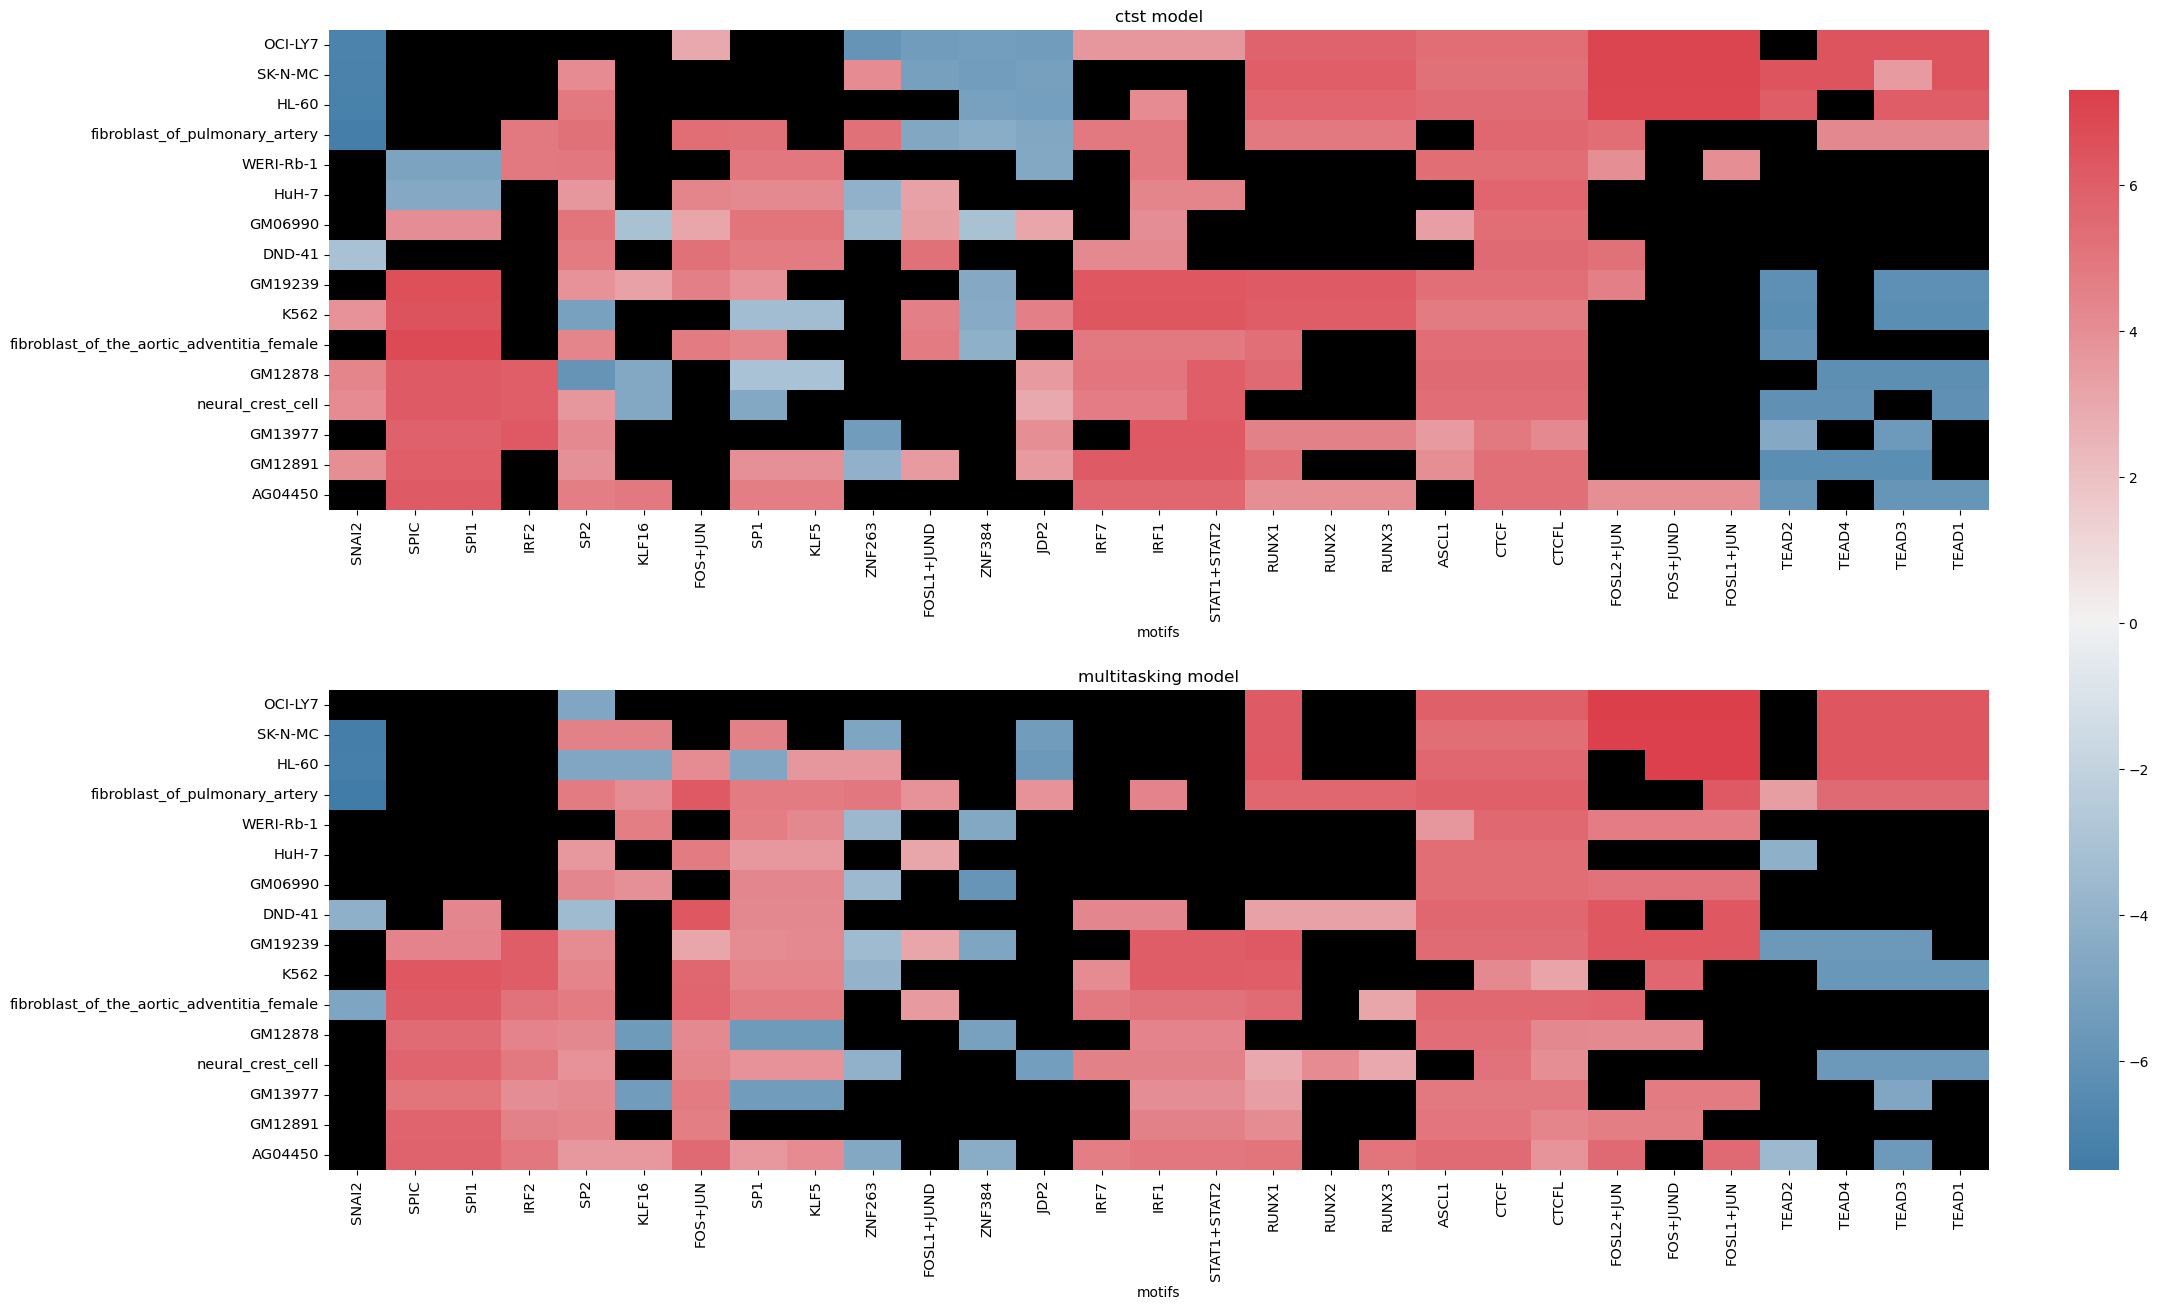

In [11]:
#let's make same celltypes as seen in the FIMO analysis!!
#we need to account for removing the nans and removing the repeats keeping only the smallest q value!
qvals_threshold = .15
import re
import os
import pandas as pd
import numpy as np
directory = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/all_celltypes/reports/'
dict_value = 0
match_dict = {}
seqlets_list = []
seqlets_list_ctst = []
qvals_list = []
qvals_list_ctst = []
match_list = []
match_list_ctst = []

def numerical_sort(value): #this is a regex that uses the actual numbers to sort like 99 is before 100, but sorted(dir) does ls type sorting
    """Extracts numbers from a filename for sorting."""
    numbers = re.compile(r'(\d+)')  # Compiles a regex to find numbers
    parts = numbers.split(value)    # Splits the filename at each number
    parts[1::2] = map(int, parts[1::2])  # Converts all numeric strings to integers
    return parts

sorted_files = sorted(os.listdir(directory), key=numerical_sort)



for subdir in sorted_files:
    #first we go through the list of all the files, whether it's multitasking or ctst
    #these are the tfmodisco results
    # print(subdir) #does indeed print it in the ls order, so we need to chagne this
    # continue
    tables = pd.read_html(directory+subdir+'/'+'motifs.html')
    df = tables[0]
    #then we read in the html file and make it a table
    
    #now what we do is create
    qvals = pd.concat([df['qval0'],df['qval1'],df['qval2']], axis=0).to_numpy()
    matches = pd.concat([df['match0'],df['match1'],df['match2']], axis=0).to_numpy()
    seqs = pd.concat([df['num_seqlets'],df['num_seqlets'],df['num_seqlets']], axis=0).to_numpy()
    posneg = pd.concat([df['pattern'],df['pattern'],df['pattern']], axis=0).to_numpy()
    new_df = pd.DataFrame({
        'qvals': pd.concat([df['qval0'], df['qval1'], df['qval2']]),
        'matches': pd.concat([df['match0'], df['match1'], df['match2']]),
        'seqs': pd.concat([df['num_seqlets'], df['num_seqlets'], df['num_seqlets']]),  # Assuming repetition is intended
        'posneg': pd.concat([df['pattern'], df['pattern'], df['pattern']])  # Assuming repetition is intended
    })
    new_df.reset_index(drop=True, inplace=True)

    #now we filter out the low q values
    new_df = new_df[new_df['qvals'] < qvals_threshold]
    #and drop any rows that have an nan
    new_df = new_df.dropna()
    #and we change posneg to actually be positive oro negative
    new_df['posneg'] = new_df['posneg'].apply(lambda x: 1 if x.startswith('pos') else -1)
    #finally we sort it and drop duplicates based on the q value
    new_df = new_df.sort_values(by='qvals').drop_duplicates(subset='matches', keep='first')
    newmatch = new_df['matches'].to_numpy()
    newq = new_df['qvals'].to_numpy()
    newseqs = new_df['seqs'].to_numpy()
    posneg = new_df['posneg'].to_numpy()

    #now let's do this same check
    if len(np.unique(newmatch)) < len(newmatch):
        print('ERRRORRRRRRRR')

    for match in newmatch: #basically for each element, if it's not somethign new, we add it to the dictionary
        if match not in match_dict:
            match_dict[match] = dict_value
            dict_value += 1
    if 'mult' in subdir: #now if it' smultitasking, we append them all to the multitasking value
        match_list.append(newmatch) #now store it as a list of lists, where the element corresponding to this cre
        qvals_list.append(newq * posneg) #multiply by posneg to make it negative if it's a negative peak
        seqlets_list.append(newseqs * posneg) #multiply by posneg to make it negative if it's a negative peak
    elif 'ctst' in subdir:
        match_list_ctst.append(newmatch)
        qvals_list_ctst.append(newq * posneg)
        seqlets_list_ctst.append(newseqs * posneg)
    else:
        print('error')
        break
#still jsut a few seconds! This is great!!

full_array = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_ctst = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets_ctst = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
#now we go through all the different qvals_list which is actually just 160
for cell_idx in range(len(qvals_list)): #basically just go through each celltype!
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list[cell_idx]): #now go through the keys which is the motif name for each match in that celltype
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match] #here we find the index of the match in the dictionary
        full_array[match_idx, cell_idx] = qvals_list[cell_idx][counter] #now asign via motif number and celltype based on the celltype we have!
        full_array_seqlets[match_idx, cell_idx] = seqlets_list[cell_idx][counter]

for cell_idx in range(len(qvals_list_ctst)):
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list_ctst[cell_idx]):
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match]
        # print(match_idx)
        # print(cell_idx)
        #then we can set the value
        full_array_ctst[match_idx, cell_idx] = qvals_list_ctst[cell_idx][counter]
        full_array_seqlets_ctst[match_idx, cell_idx] = seqlets_list_ctst[cell_idx][counter]

dict_keys = list(match_dict.keys())
dict_keys_short = [item[:-9] if len(item) > 9 else item for item in dict_keys]


import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm, Normalize
def multi_modisco_summary(results_list, dict_keys, name_list, mask_list, cluster_index = 0, type='qval', fontsize = 5.5, logscale=False, cell_idxs=None):
    # global_min = min([i.min() for i in results_list])
    # global_max = max([i.max() for i in results_list])
    if type == 'qval':        
        global_min = -.05
        global_max = .05
    elif type == 'seqlets':
        global_min = min([i.min() for i in results_list])
        global_max = max([i.max() for i in results_list])
        if logscale:
            global_min = -np.log(np.abs(global_min+1e-6))
            global_max = np.log(global_max+1e-6)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    cmap.set_bad('k')
    #let's load in the celltype_idx
    celltypesfile = '/data/leslie/sarthak/data/cCRE_celltype_matrices/cell_types_filtered.txt'
    celltypes = []
    with open(celltypesfile) as f:
        for counter,line in enumerate(f):
            if cell_idxs is None or counter in cell_idxs: #basically we either do all of them or just this subset!!
                celltypes.append(line.strip())

    #uses index to determine which model in results list is used for clustering
    i = results_list[cluster_index]
    g = sns.clustermap(i.T, cmap = cmap, center = 0, vmin=global_min, vmax=global_max, figsize=(20,5), mask=mask_list[cluster_index].T)
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    plt.close(g.figure)

    fig = plt.figure(figsize=(20, 6*len(results_list)))
    # from matplotlib.colors import TwoSlopeNorm

    # Dimensions for main and secondary heatmaps
    main_heatmap_width = .83
    gap_between_heatmaps = 0.01
    height = 0.8/len(results_list)  # Adjust based on your preference for the subplot height
    vertical_gap = 0.3/len(results_list)  # Gap between rows

    main_left = 0.05  # Starting position of the main heatmap (left)
    # temp_true = true_values[row_order].unsqueeze(1)

    for j, i in enumerate(results_list):
        # Calculate positions of main and secondary heatmaps    
        bottom = 0.1 + (height + vertical_gap) * (len(results_list) - 1 - j)  # Starting position from bottom, adjust for each row
        # bottom = 1 - (vertical_gap + (j+1) * total_vertical_space_per_heatmap) #doesn't work, let's figure out why

        ax_main = fig.add_axes([main_left, bottom, main_heatmap_width, height])

        temp_values = i.T
        if logscale:
            #log the data
            sign = np.sign(temp_values)
            temp_values = np.log(np.abs(temp_values)+.1e-6)*sign

        if j == len(results_list)-1:
            continue
        sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                    ax=ax_main, cbar=False, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                    yticklabels = np.array(celltypes)[row_order])
        ax_main.set_xlabel('motifs', fontsize = ofntsize+2)
        ax_main.set_title(f'{name_list[j]} model')
        #make xticklabels smaller
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize = fontsize)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([.92, 0.1, 0.025, 0.9])  

    #let's redraw the last one so we can easily draw the colorbars
    # temp_values = temp_values[row_order]
    # temp_values = temp_values[:,col_order]
    sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                ax=ax_main, cbar_ax=cbar_ax, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                yticklabels=np.array(celltypes)[row_order])
    # temp_values[np.ix_(row_order,col_order)]
    ax_main.set_xlabel('motifs', fontsize = fontsize+2)
    ax_main.set_title(f'{name_list[j]} model')
    #and make fontsizes smaller
    ax_main.set_xticklabels(ax_main.get_xticklabels(), fontsize=fontsize)
    ax_main.set_yticklabels(ax_main.get_yticklabels(), fontsize=fontsize)

cell_idxs = [11, 14, 54, 24, 156, 154, 153, 17, 95, 51, 43, 114, 39, 137, 74, 83]
filtered_array_seq = full_array_seqlets[:,cell_idxs]
filtered_array_seq_ctst = full_array_seqlets_ctst[:,cell_idxs]
temp = (filtered_array_seq_ctst!=0) + (filtered_array_seq!=0) #essentially need at least 3 elements to be non zero
temp = temp.sum(1)
rows = np.where(temp > 8)[0]
new_dict_list = [dict_keys[i][:-9] for i in range(len(dict_keys)) if i in rows]
filtered_array_seq_ctst = filtered_array_seq_ctst[rows]
filtered_array_seq = filtered_array_seq[rows]
multi_modisco_summary([-filtered_array_seq_ctst, -filtered_array_seq], new_dict_list, ['ctst', 'multitasking'], [filtered_array_seq_ctst == 0, filtered_array_seq == 0], cluster_index = 0, type='seqlets', 
                      fontsize=10.5, logscale=True, cell_idxs=cell_idxs)

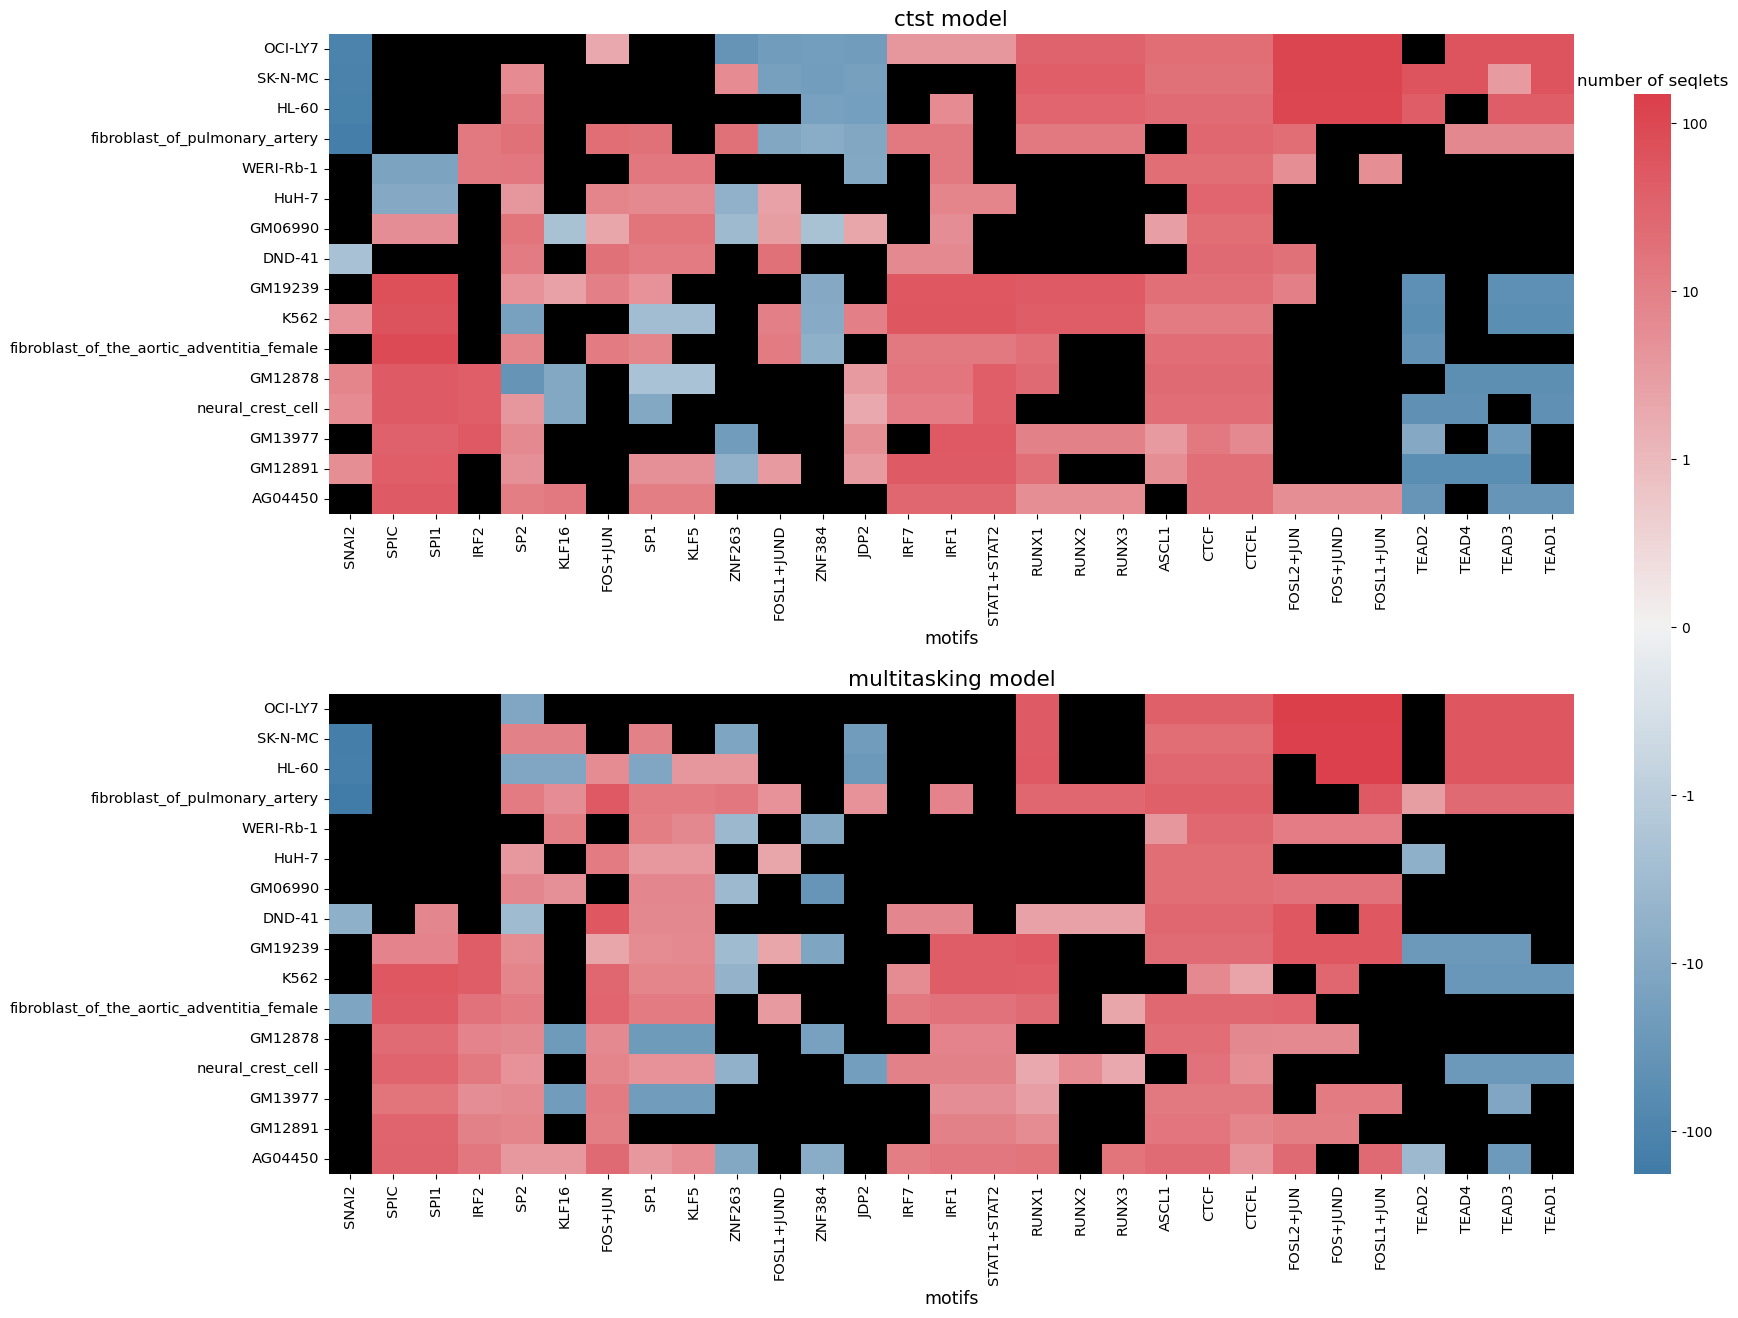

In [35]:
def multi_modisco_summary(results_list, dict_keys, name_list, mask_list, cluster_index = 0, type='qval', fontsize = 5.5, logscale=False, cell_idxs=None):
    # global_min = min([i.min() for i in results_list])
    # global_max = max([i.max() for i in results_list])
    if type == 'qval':        
        global_min = -.05
        global_max = .05
    elif type == 'seqlets':
        global_min = min([i.min() for i in results_list])
        global_max = max([i.max() for i in results_list])
        if logscale:
            global_min = -np.log(np.abs(global_min+1e-6))
            global_max = np.log(global_max+1e-6)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    cmap.set_bad('k')
    #let's load in the celltype_idx
    celltypesfile = '/data/leslie/sarthak/data/cCRE_celltype_matrices/cell_types_filtered.txt'
    celltypes = []
    with open(celltypesfile) as f:
        for counter,line in enumerate(f):
            if cell_idxs is None or counter in cell_idxs: #basically we either do all of them or just this subset!!
                celltypes.append(line.strip())

    #uses index to determine which model in results list is used for clustering
    i = results_list[cluster_index]
    g = sns.clustermap(i.T, cmap = cmap, center = 0, vmin=global_min, vmax=global_max, figsize=(20,5), mask=mask_list[cluster_index].T)
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    plt.close(g.figure)

    fig = plt.figure(figsize=(15, 6*len(results_list)))
    # from matplotlib.colors import TwoSlopeNorm

    # Dimensions for main and secondary heatmaps
    main_heatmap_width = .83
    gap_between_heatmaps = 0.01
    height = 0.8/len(results_list)  # Adjust based on your preference for the subplot height
    vertical_gap = 0.3/len(results_list)  # Gap between rows

    main_left = 0.05  # Starting position of the main heatmap (left)
    # temp_true = true_values[row_order].unsqueeze(1)

    for j, i in enumerate(results_list):
        # Calculate positions of main and secondary heatmaps    
        bottom = 0.1 + (height + vertical_gap) * (len(results_list) - 1 - j)  # Starting position from bottom, adjust for each row
        # bottom = 1 - (vertical_gap + (j+1) * total_vertical_space_per_heatmap) #doesn't work, let's figure out why

        ax_main = fig.add_axes([main_left, bottom, main_heatmap_width, height])

        temp_values = i.T
        if logscale:
            #log the data
            sign = np.sign(temp_values)
            temp_values = np.log(np.abs(temp_values)+.1e-6)*sign

        if j == len(results_list)-1:
            continue
        sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                    ax=ax_main, cbar=False, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                    yticklabels = np.array(celltypes)[row_order])
        ax_main.set_xlabel('motifs', fontsize = fontsize+2)
        ax_main.set_title(f'{name_list[j]} model', fontsize = fontsize+5)
        #make xticklabels smaller
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize = fontsize)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([.92, 0.1, 0.025, 0.9])
    cbar_ax.set_title('number of seqlets')

    #let's redraw the last one so we can easily draw the colorbars
    # temp_values = temp_values[row_order]
    # temp_values = temp_values[:,col_order]
    sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                ax=ax_main, cbar_ax=cbar_ax, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                yticklabels=np.array(celltypes)[row_order])
    # temp_values[np.ix_(row_order,col_order)]
    ax_main.set_xlabel('motifs', fontsize = fontsize+2)
    ax_main.set_title(f'{name_list[j]} model', fontsize = fontsize+5)
    #and make fontsizes smaller
    ax_main.set_xticklabels(ax_main.get_xticklabels(), fontsize=fontsize)
    ax_main.set_yticklabels(ax_main.get_yticklabels(), fontsize=fontsize)
    cbar_ax.set_yticks([-6.9,-4.6,-2.3,0,2.3,4.6,6.9])
    cbar_ax.set_yticklabels([-100,-10,-1,0,1,10,100])

cell_idxs = [11, 14, 54, 24, 156, 154, 153, 17, 95, 51, 43, 114, 39, 137, 74, 83]
filtered_array_seq = full_array_seqlets[:,cell_idxs]
filtered_array_seq_ctst = full_array_seqlets_ctst[:,cell_idxs]
temp = (filtered_array_seq_ctst!=0) + (filtered_array_seq!=0) #essentially need at least 3 elements to be non zero
temp = temp.sum(1)
rows = np.where(temp > 8)[0]
new_dict_list = [dict_keys[i][:-9] for i in range(len(dict_keys)) if i in rows]
filtered_array_seq_ctst = filtered_array_seq_ctst[rows]
filtered_array_seq = filtered_array_seq[rows]
multi_modisco_summary([-filtered_array_seq_ctst, -filtered_array_seq], new_dict_list, ['ctst', 'multitasking'], [filtered_array_seq_ctst == 0, filtered_array_seq == 0], cluster_index = 0, type='seqlets', 
                      fontsize=10.5, logscale=True, cell_idxs=cell_idxs)

In [21]:
np.log([1,10,100,1000])

array([0.        , 2.30258509, 4.60517019, 6.90775528])

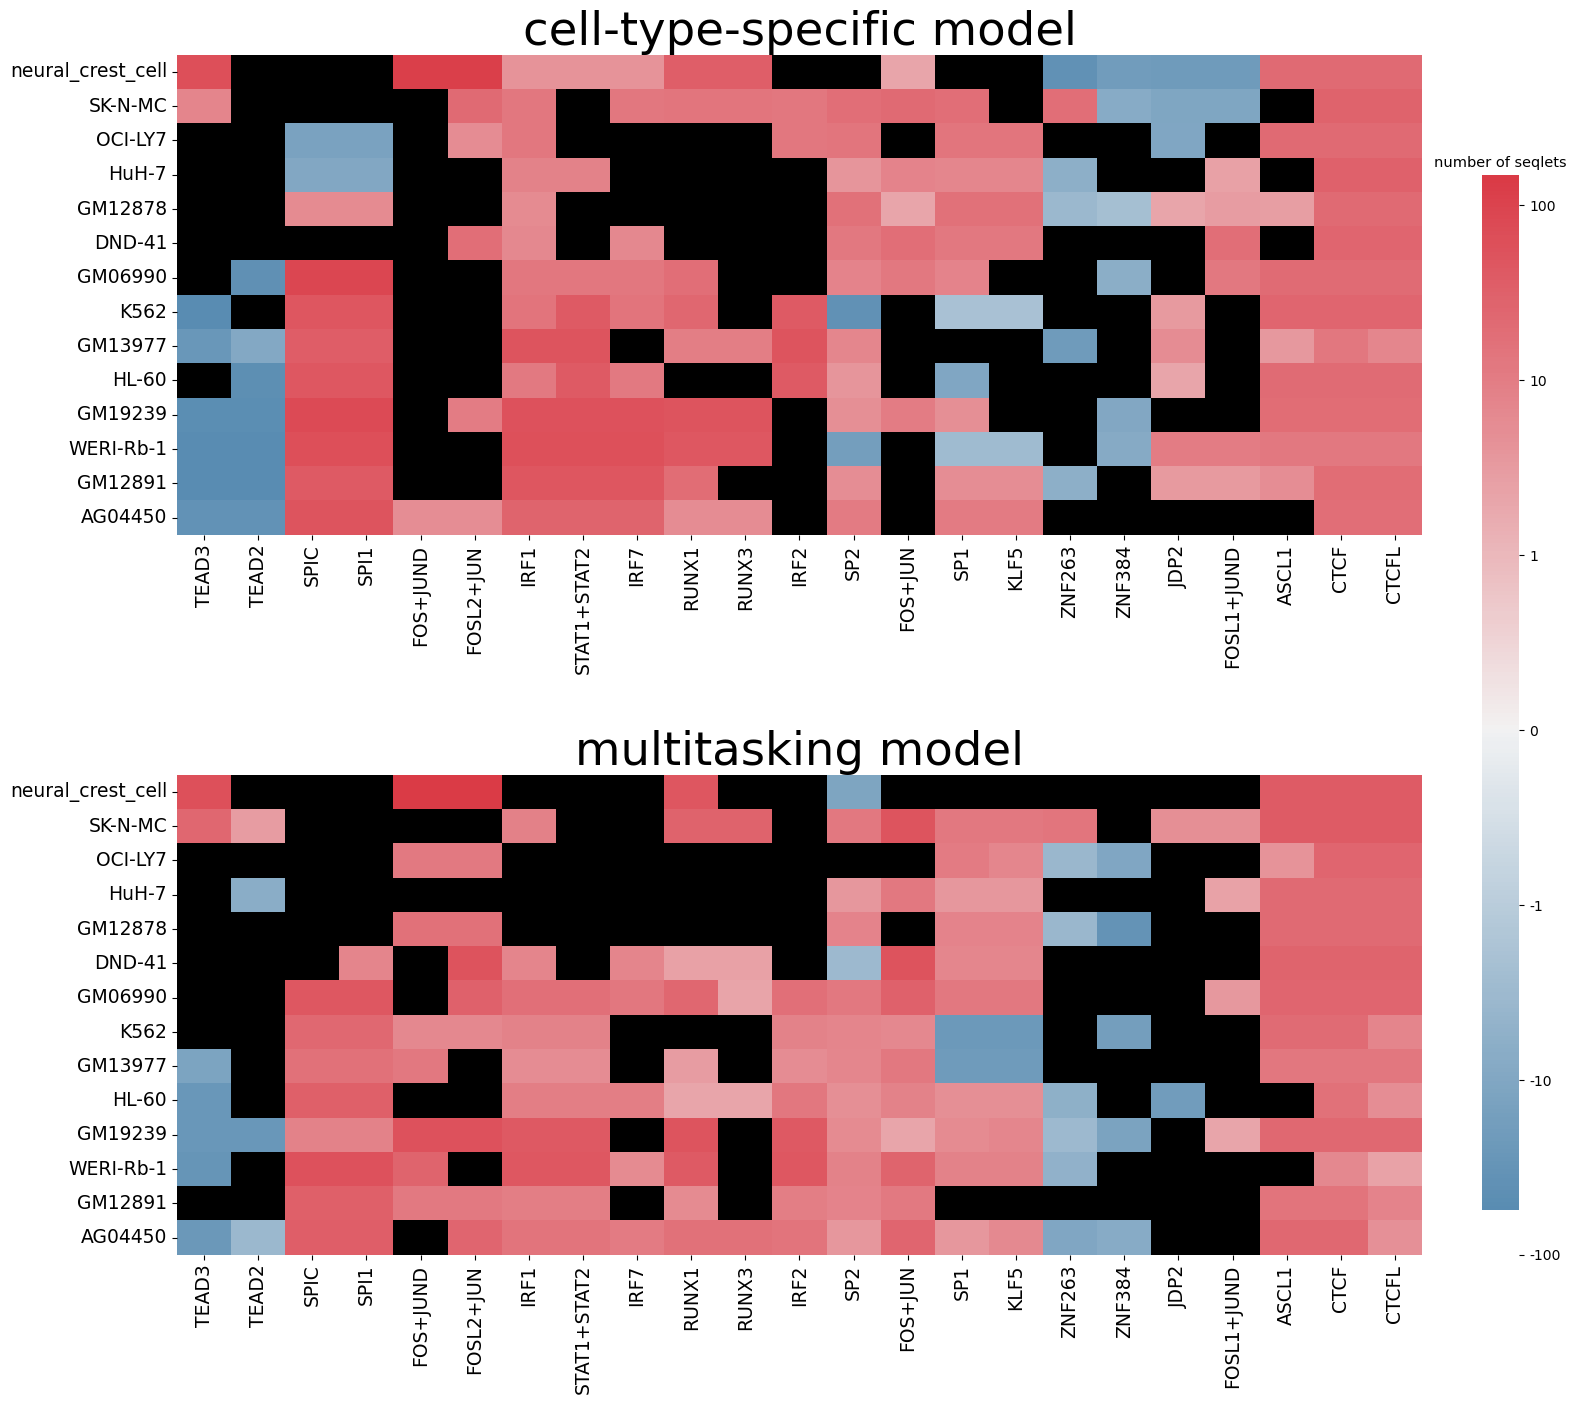

In [4]:
#let's remake the plot with getting rid of the motifs x label, making the title bigger changing the name to be smarter and less long, so like remove the plus
#nah keep the plus but make it tilted for example

qvals_threshold = .15
import re
import os
import pandas as pd
import numpy as np
directory = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/all_celltypes/reports/'
dict_value = 0
match_dict = {}
seqlets_list = []
seqlets_list_ctst = []
qvals_list = []
qvals_list_ctst = []
match_list = []
match_list_ctst = []

def numerical_sort(value): #this is a regex that uses the actual numbers to sort like 99 is before 100, but sorted(dir) does ls type sorting
    """Extracts numbers from a filename for sorting."""
    numbers = re.compile(r'(\d+)')  # Compiles a regex to find numbers
    parts = numbers.split(value)    # Splits the filename at each number
    parts[1::2] = map(int, parts[1::2])  # Converts all numeric strings to integers
    return parts

sorted_files = sorted(os.listdir(directory), key=numerical_sort)



for subdir in sorted_files:
    #first we go through the list of all the files, whether it's multitasking or ctst
    #these are the tfmodisco results
    # print(subdir) #does indeed print it in the ls order, so we need to chagne this
    # continue
    tables = pd.read_html(directory+subdir+'/'+'motifs.html')
    df = tables[0]
    #then we read in the html file and make it a table
    
    #now what we do is create
    qvals = pd.concat([df['qval0'],df['qval1'],df['qval2']], axis=0).to_numpy()
    matches = pd.concat([df['match0'],df['match1'],df['match2']], axis=0).to_numpy()
    seqs = pd.concat([df['num_seqlets'],df['num_seqlets'],df['num_seqlets']], axis=0).to_numpy()
    posneg = pd.concat([df['pattern'],df['pattern'],df['pattern']], axis=0).to_numpy()
    new_df = pd.DataFrame({
        'qvals': pd.concat([df['qval0'], df['qval1'], df['qval2']]),
        'matches': pd.concat([df['match0'], df['match1'], df['match2']]),
        'seqs': pd.concat([df['num_seqlets'], df['num_seqlets'], df['num_seqlets']]),  # Assuming repetition is intended
        'posneg': pd.concat([df['pattern'], df['pattern'], df['pattern']])  # Assuming repetition is intended
    })
    new_df.reset_index(drop=True, inplace=True)

    #now we filter out the low q values
    new_df = new_df[new_df['qvals'] < qvals_threshold]
    #and drop any rows that have an nan
    new_df = new_df.dropna()
    #and we change posneg to actually be positive oro negative
    new_df['posneg'] = new_df['posneg'].apply(lambda x: 1 if x.startswith('pos') else -1)
    #finally we sort it and drop duplicates based on the q value
    new_df = new_df.sort_values(by='qvals').drop_duplicates(subset='matches', keep='first')
    newmatch = new_df['matches'].to_numpy()
    newq = new_df['qvals'].to_numpy()
    newseqs = new_df['seqs'].to_numpy()
    posneg = new_df['posneg'].to_numpy()

    #now let's do this same check
    if len(np.unique(newmatch)) < len(newmatch):
        print('ERRRORRRRRRRR')

    for match in newmatch: #basically for each element, if it's not somethign new, we add it to the dictionary
        if match not in match_dict:
            match_dict[match] = dict_value
            dict_value += 1
    if 'mult' in subdir: #now if it' smultitasking, we append them all to the multitasking value
        match_list.append(newmatch) #now store it as a list of lists, where the element corresponding to this cre
        qvals_list.append(newq * posneg) #multiply by posneg to make it negative if it's a negative peak
        seqlets_list.append(newseqs * posneg) #multiply by posneg to make it negative if it's a negative peak
    elif 'ctst' in subdir:
        match_list_ctst.append(newmatch)
        qvals_list_ctst.append(newq * posneg)
        seqlets_list_ctst.append(newseqs * posneg)
    else:
        print('error')
        break
#still jsut a few seconds! This is great!!

full_array = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_ctst = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets_ctst = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
#now we go through all the different qvals_list which is actually just 160
for cell_idx in range(len(qvals_list)): #basically just go through each celltype!
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list[cell_idx]): #now go through the keys which is the motif name for each match in that celltype
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match] #here we find the index of the match in the dictionary
        full_array[match_idx, cell_idx] = qvals_list[cell_idx][counter] #now asign via motif number and celltype based on the celltype we have!
        full_array_seqlets[match_idx, cell_idx] = seqlets_list[cell_idx][counter]

for cell_idx in range(len(qvals_list_ctst)):
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list_ctst[cell_idx]):
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match]
        # print(match_idx)
        # print(cell_idx)
        #then we can set the value
        full_array_ctst[match_idx, cell_idx] = qvals_list_ctst[cell_idx][counter]
        full_array_seqlets_ctst[match_idx, cell_idx] = seqlets_list_ctst[cell_idx][counter]

dict_keys = list(match_dict.keys())
dict_keys_short = [item[:-9] if len(item) > 9 else item for item in dict_keys]


import seaborn as sns
import matplotlib.pyplot as plt

def multi_modisco_summary(results_list, dict_keys, name_list, mask_list, cluster_index = 0, type='qval', fontsize = 5.5, logscale=False, cell_idxs=None):
    # global_min = min([i.min() for i in results_list])
    # global_max = max([i.max() for i in results_list])
    if type == 'qval':        
        global_min = -.05
        global_max = .05
    elif type == 'seqlets':
        global_min = min([i.min() for i in results_list])
        global_max = max([i.max() for i in results_list])
        if logscale:
            global_min = -np.log(np.abs(global_min+1e-6))
            global_max = np.log(global_max+1e-6)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    cmap.set_bad('k')
    #let's load in the celltype_idx
    celltypesfile = '/data/leslie/sarthak/data/cCRE_celltype_matrices/cell_types_filtered.txt'
    celltypes = []
    with open(celltypesfile) as f:
        for counter,line in enumerate(f):
            if cell_idxs is None or counter in cell_idxs: #basically we either do all of them or just this subset!!
                celltypes.append(line.strip())

    #uses index to determine which model in results list is used for clustering
    i = results_list[cluster_index]
    g = sns.clustermap(i.T, cmap = cmap, center = 0, vmin=global_min, vmax=global_max, figsize=(20,5), mask=mask_list[cluster_index].T)
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    plt.close(g.figure)

    fig = plt.figure(figsize=(15, 6*len(results_list)))
    # from matplotlib.colors import TwoSlopeNorm

    # Dimensions for main and secondary heatmaps
    main_heatmap_width = .83
    gap_between_heatmaps = 0.01
    height = 0.8/len(results_list)  # Adjust based on your preference for the subplot height
    vertical_gap = 0.4/len(results_list)  # Gap between rows

    main_left = 0.05  # Starting position of the main heatmap (left)
    # temp_true = true_values[row_order].unsqueeze(1)

    for j, i in enumerate(results_list):
        # Calculate positions of main and secondary heatmaps    
        bottom = 0.1 + (height + vertical_gap) * (len(results_list) - 1 - j)  # Starting position from bottom, adjust for each row
        # bottom = 1 - (vertical_gap + (j+1) * total_vertical_space_per_heatmap) #doesn't work, let's figure out why

        ax_main = fig.add_axes([main_left, bottom, main_heatmap_width, height])

        temp_values = i.T
        if logscale:
            #log the data
            sign = np.sign(temp_values)
            temp_values = np.log(np.abs(temp_values)+.1e-6)*sign

        if j == len(results_list)-1:
            continue
        sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                    ax=ax_main, cbar=False, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                    yticklabels = np.array(celltypes)[row_order])
        # ax_main.set_xlabel('motifs', fontsize = fontsize+2)
        ax_main.set_title(f'{name_list[j]} model', fontsize = fontsize+20)
        #make xticklabels smaller
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize = fontsize)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([.92, 0.1, 0.025, 0.9])
    cbar_ax.set_title('number of seqlets', fontsize = fontsize-3)

    #let's redraw the last one so we can easily draw the colorbars
    # temp_values = temp_values[row_order]
    # temp_values = temp_values[:,col_order]
    sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                ax=ax_main, cbar_ax=cbar_ax, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                yticklabels=np.array(celltypes)[row_order])
    # temp_values[np.ix_(row_order,col_order)]
    # ax_main.set_xlabel('motifs', fontsize = fontsize+2)
    ax_main.set_title(f'{name_list[j]} model', fontsize = fontsize+20)
    #and make fontsizes smaller
    ax_main.set_xticklabels(ax_main.get_xticklabels(), fontsize=fontsize)
    ax_main.set_yticklabels(ax_main.get_yticklabels(), fontsize=fontsize)
    cbar_ax.set_yticks([-6.9,-4.6,-2.3,0,2.3,4.6,6.9])
    cbar_ax.set_yticklabels([-100,-10,-1,0,1,10,100])

cell_idxs = [11, 14, 54, 24, 156, 154, 153, 17, 95, 51, 114, 39, 137, 83]
filtered_array_seq = full_array_seqlets[:,cell_idxs]
filtered_array_seq_ctst = full_array_seqlets_ctst[:,cell_idxs]
temp = (filtered_array_seq_ctst!=0) + (filtered_array_seq!=0) #essentially need at least 3 elements to be non zero
temp = temp.sum(1)
rows = np.where(temp > 8)[0]
new_dict_list = [dict_keys[i][:-9] for i in range(len(dict_keys)) if i in rows]
filtered_array_seq_ctst = filtered_array_seq_ctst[rows]
filtered_array_seq = filtered_array_seq[rows]
multi_modisco_summary([-filtered_array_seq_ctst, -filtered_array_seq], new_dict_list, ['cell-type-specific', 'multitasking'], [filtered_array_seq_ctst == 0, filtered_array_seq == 0], cluster_index = 0, type='seqlets', 
                      fontsize=13.5, logscale=True, cell_idxs=cell_idxs)

14
14


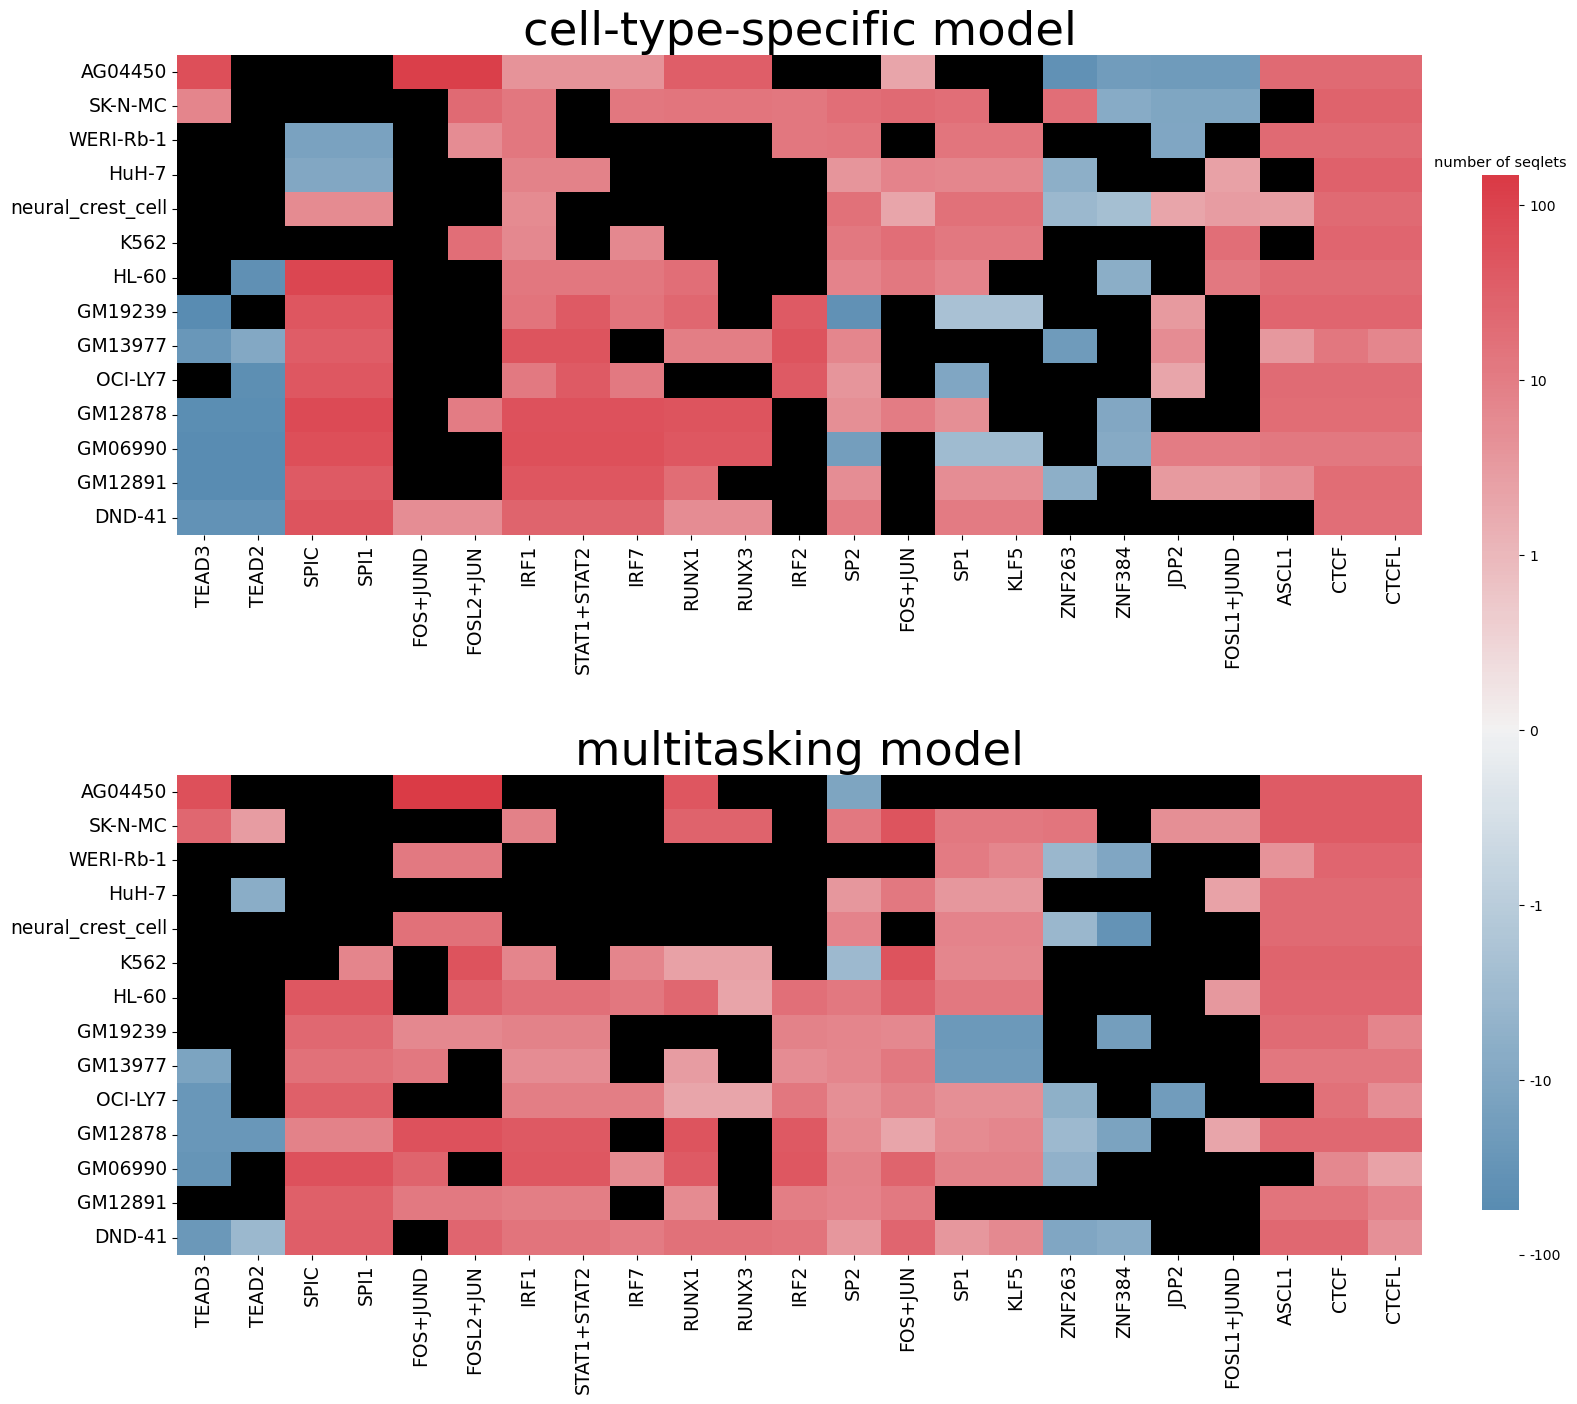

In [5]:
#let's remake the plot with getting rid of the motifs x label, making the title bigger changing the name to be smarter and less long, so like remove the plus
#nah keep the plus but make it tilted for example

qvals_threshold = .15
import re
import os
import pandas as pd
import numpy as np
directory = '/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/modisco/all_celltypes/reports/'
dict_value = 0
match_dict = {}
seqlets_list = []
seqlets_list_ctst = []
qvals_list = []
qvals_list_ctst = []
match_list = []
match_list_ctst = []

def numerical_sort(value): #this is a regex that uses the actual numbers to sort like 99 is before 100, but sorted(dir) does ls type sorting
    """Extracts numbers from a filename for sorting."""
    numbers = re.compile(r'(\d+)')  # Compiles a regex to find numbers
    parts = numbers.split(value)    # Splits the filename at each number
    parts[1::2] = map(int, parts[1::2])  # Converts all numeric strings to integers
    return parts

sorted_files = sorted(os.listdir(directory), key=numerical_sort)



for subdir in sorted_files:
    #first we go through the list of all the files, whether it's multitasking or ctst
    #these are the tfmodisco results
    # print(subdir) #does indeed print it in the ls order, so we need to chagne this
    # continue
    tables = pd.read_html(directory+subdir+'/'+'motifs.html')
    df = tables[0]
    #then we read in the html file and make it a table
    
    #now what we do is create
    qvals = pd.concat([df['qval0'],df['qval1'],df['qval2']], axis=0).to_numpy()
    matches = pd.concat([df['match0'],df['match1'],df['match2']], axis=0).to_numpy()
    seqs = pd.concat([df['num_seqlets'],df['num_seqlets'],df['num_seqlets']], axis=0).to_numpy()
    posneg = pd.concat([df['pattern'],df['pattern'],df['pattern']], axis=0).to_numpy()
    new_df = pd.DataFrame({
        'qvals': pd.concat([df['qval0'], df['qval1'], df['qval2']]),
        'matches': pd.concat([df['match0'], df['match1'], df['match2']]),
        'seqs': pd.concat([df['num_seqlets'], df['num_seqlets'], df['num_seqlets']]),  # Assuming repetition is intended
        'posneg': pd.concat([df['pattern'], df['pattern'], df['pattern']])  # Assuming repetition is intended
    })
    new_df.reset_index(drop=True, inplace=True)

    #now we filter out the low q values
    new_df = new_df[new_df['qvals'] < qvals_threshold]
    #and drop any rows that have an nan
    new_df = new_df.dropna()
    #and we change posneg to actually be positive oro negative
    new_df['posneg'] = new_df['posneg'].apply(lambda x: 1 if x.startswith('pos') else -1)
    #finally we sort it and drop duplicates based on the q value
    new_df = new_df.sort_values(by='qvals').drop_duplicates(subset='matches', keep='first')
    newmatch = new_df['matches'].to_numpy()
    newq = new_df['qvals'].to_numpy()
    newseqs = new_df['seqs'].to_numpy()
    posneg = new_df['posneg'].to_numpy()

    #now let's do this same check
    if len(np.unique(newmatch)) < len(newmatch):
        print('ERRRORRRRRRRR')

    for match in newmatch: #basically for each element, if it's not somethign new, we add it to the dictionary
        if match not in match_dict:
            match_dict[match] = dict_value
            dict_value += 1
    if 'mult' in subdir: #now if it' smultitasking, we append them all to the multitasking value
        match_list.append(newmatch) #now store it as a list of lists, where the element corresponding to this cre
        qvals_list.append(newq * posneg) #multiply by posneg to make it negative if it's a negative peak
        seqlets_list.append(newseqs * posneg) #multiply by posneg to make it negative if it's a negative peak
    elif 'ctst' in subdir:
        match_list_ctst.append(newmatch)
        qvals_list_ctst.append(newq * posneg)
        seqlets_list_ctst.append(newseqs * posneg)
    else:
        print('error')
        break
#still jsut a few seconds! This is great!!

full_array = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_ctst = np.ones((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
full_array_seqlets_ctst = np.zeros((len(match_dict), len(qvals_list))) #this is num_unique motifs to num_celltypes
#now we go through all the different qvals_list which is actually just 160
for cell_idx in range(len(qvals_list)): #basically just go through each celltype!
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list[cell_idx]): #now go through the keys which is the motif name for each match in that celltype
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match] #here we find the index of the match in the dictionary
        full_array[match_idx, cell_idx] = qvals_list[cell_idx][counter] #now asign via motif number and celltype based on the celltype we have!
        full_array_seqlets[match_idx, cell_idx] = seqlets_list[cell_idx][counter]

for cell_idx in range(len(qvals_list_ctst)):
    #we are iterating through the celltypes
    for counter,match in enumerate(match_list_ctst[cell_idx]):
        #this iterates through the matches, then we find the index by the match_dict
        match_idx = match_dict[match]
        # print(match_idx)
        # print(cell_idx)
        #then we can set the value
        full_array_ctst[match_idx, cell_idx] = qvals_list_ctst[cell_idx][counter]
        full_array_seqlets_ctst[match_idx, cell_idx] = seqlets_list_ctst[cell_idx][counter]

dict_keys = list(match_dict.keys())
dict_keys_short = [item[:-9] if len(item) > 9 else item for item in dict_keys]


import seaborn as sns
import matplotlib.pyplot as plt

def multi_modisco_summary(results_list, dict_keys, name_list, mask_list, cluster_index = 0, type='qval', fontsize = 5.5, logscale=False, cell_idxs=None):
    # global_min = min([i.min() for i in results_list])
    # global_max = max([i.max() for i in results_list])
    if type == 'qval':        
        global_min = -.05
        global_max = .05
    elif type == 'seqlets':
        global_min = min([i.min() for i in results_list])
        global_max = max([i.max() for i in results_list])
        if logscale:
            global_min = -np.log(np.abs(global_min+1e-6))
            global_max = np.log(global_max+1e-6)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    cmap.set_bad('k')
    #let's load in the celltype_idx
    celltypesfile = '/data/leslie/sarthak/data/cCRE_celltype_matrices/cell_types_filtered.txt'
    celltypes = []
    with open(celltypesfile) as f:
        for counter,line in enumerate(f):
            # if cell_idxs is None or counter in cell_idxs: #basically we either do all of them or just this subset!!
            celltypes.append(line.strip())
    if cell_idxs is not None: #have to do it this way, because the order does matter!! Unless we ordered it first which we did not!!
        celltypes = np.array(celltypes)[cell_idxs]
    print(len(celltypes))

    #uses index to determine which model in results list is used for clustering
    i = results_list[cluster_index]
    g = sns.clustermap(i.T, cmap = cmap, center = 0, vmin=global_min, vmax=global_max, figsize=(20,5), mask=mask_list[cluster_index].T)
    row_order = g.dendrogram_row.reordered_ind
    col_order = g.dendrogram_col.reordered_ind
    plt.close(g.figure)
    print(len(row_order))

    fig = plt.figure(figsize=(15, 6*len(results_list)))
    # from matplotlib.colors import TwoSlopeNorm

    # Dimensions for main and secondary heatmaps
    main_heatmap_width = .83
    gap_between_heatmaps = 0.01
    height = 0.8/len(results_list)  # Adjust based on your preference for the subplot height
    vertical_gap = 0.4/len(results_list)  # Gap between rows

    main_left = 0.05  # Starting position of the main heatmap (left)
    # temp_true = true_values[row_order].unsqueeze(1)

    for j, i in enumerate(results_list):
        # Calculate positions of main and secondary heatmaps    
        bottom = 0.1 + (height + vertical_gap) * (len(results_list) - 1 - j)  # Starting position from bottom, adjust for each row
        # bottom = 1 - (vertical_gap + (j+1) * total_vertical_space_per_heatmap) #doesn't work, let's figure out why

        ax_main = fig.add_axes([main_left, bottom, main_heatmap_width, height])

        temp_values = i.T
        if logscale:
            #log the data
            sign = np.sign(temp_values)
            temp_values = np.log(np.abs(temp_values)+.1e-6)*sign

        if j == len(results_list)-1:
            continue
        sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                    ax=ax_main, cbar=False, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                    yticklabels = celltypes[row_order])
        # ax_main.set_xlabel('motifs', fontsize = fontsize+2)
        ax_main.set_title(f'{name_list[j]} model', fontsize = fontsize+20)
        #make xticklabels smaller
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize = fontsize)

    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([.92, 0.1, 0.025, 0.9])
    cbar_ax.set_title('number of seqlets', fontsize = fontsize-3)

    #let's redraw the last one so we can easily draw the colorbars
    # temp_values = temp_values[row_order]
    # temp_values = temp_values[:,col_order]
    sns.heatmap(temp_values[np.ix_(row_order,col_order)], cmap=cmap, mask = mask_list[j].T[np.ix_(row_order,col_order)], center=0,
                ax=ax_main, cbar_ax=cbar_ax, vmin=global_min, vmax=global_max, xticklabels = np.array(dict_keys)[col_order],
                yticklabels=celltypes[row_order])
    # temp_values[np.ix_(row_order,col_order)]
    # ax_main.set_xlabel('motifs', fontsize = fontsize+2)
    ax_main.set_title(f'{name_list[j]} model', fontsize = fontsize+20)
    #and make fontsizes smaller
    ax_main.set_xticklabels(ax_main.get_xticklabels(), fontsize=fontsize)
    ax_main.set_yticklabels(ax_main.get_yticklabels(), fontsize=fontsize)
    cbar_ax.set_yticks([-6.9,-4.6,-2.3,0,2.3,4.6,6.9])
    cbar_ax.set_yticklabels([-100,-10,-1,0,1,10,100])

cell_idxs = [11, 14, 54, 24, 156, 154, 153, 17, 95, 51, 114, 39, 137, 83]
filtered_array_seq = full_array_seqlets[:,cell_idxs]
filtered_array_seq_ctst = full_array_seqlets_ctst[:,cell_idxs]
temp = (filtered_array_seq_ctst!=0) + (filtered_array_seq!=0) #essentially need at least 3 elements to be non zero
temp = temp.sum(1)
rows = np.where(temp > 8)[0]
new_dict_list = [dict_keys[i][:-9] for i in range(len(dict_keys)) if i in rows]
filtered_array_seq_ctst = filtered_array_seq_ctst[rows]
filtered_array_seq = filtered_array_seq[rows]
multi_modisco_summary([-filtered_array_seq_ctst, -filtered_array_seq], new_dict_list, ['cell-type-specific', 'multitasking'], [filtered_array_seq_ctst == 0, filtered_array_seq == 0], cluster_index = 0, type='seqlets', 
                      fontsize=13.5, logscale=True, cell_idxs=cell_idxs)

In [ ]:
#maybe the way we do it is sus? why is it different based on these plots? the numbers should be the same???
#but the results are good so i don't actually know... we can revisit it, but I think we'll be ignoring these results for the most part anyways

# logoplot